# Inhalt

1. [Einleitung](#einleitung)
    - [Daten](#daten)
    - [Featurebeschreibung](#featurebeschreibung)
    - [Train Test Split](#train-test-split)
2. [EDA](#eda)
    - [Fehlende Werte](#fehlende-werte)
    - [Visualisierungen](#visualisierungen)
    - [Feature Engineering](#feature-engineering)
    - [Ausreißer](#outliers)
3. [Modellierung](#modellierung)
    - [GNB](#gnb)
    - [kNN](#knn)
    - [Entscheidungsbaum](#entscheidungsbaum)
    - [Modellauswahl](#modellauswahl)    
    - [Bootstrapping](#boostrapping)
4. [Auswertung](#auswertung)
    - [Evaluation](#evaluation)
    - [Interpretation](#interpretation)
5. [Fazit](#fazit)
6. [Reflexion](#reflexion)

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from utils import (show_missing_values, 
                   show_outliers, 
                   num_corr_heatmap, 
                   cat_corr_heatmap, 
                   cramers_v_matrix,
                   plot_confusion_matrix,
                   get_leaf_masks,
                   skfcv,
                   pipeline,
                   loocv,
                   print_cv,
                   plot_dt,
                   plot_manual_tree,
                   plot_decision_boundary,
                   bootstrapping)
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
import missingno as msno
import plotly.express as px
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
from supertree import SuperTree
import shap

In [184]:
pd.set_option('display.max_columns', 100)
RANDOM_SEED = 42

In [185]:
plt.style.use("fivethirtyeight")
SPECIES_ORDER = ["Adelie", "Chinstrap", "Gentoo"]

cycle = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

SPECIES_PALETTE = {
    "Adelie":   cycle[0],
    "Chinstrap":cycle[2],
    "Gentoo":   cycle[1],
}

SPECIES_PALETTE

{'Adelie': '#008fd5', 'Chinstrap': '#e5ae38', 'Gentoo': '#fc4f30'}

# Einleitung

Unser Ziel ist es, die Pinguinart vorherzusagen. Dabei liegt der Schwerpunkt ganz klar auf einer transparenten und gut nachvollziehbaren Modellierung. Die Interpretierbarkeit hat also Vorrang vor reiner Vorhersageleistung. Machine Learning setzen wir nur dann ein, wenn klassische, leicht nachvollziehbare statistische Verfahren an ihre Grenzen stoßen.

## Daten

Der Datensatz [palmerpenguins](https://allisonhorst.github.io/palmerpenguins/) basiert auf realen Feldmessungen, die ursprünglich von [Dr. Kristen Gorman](https://www.uaf.edu/cfos/people/faculty/detail/kristen-gorman.php) im Rahmen des [Palmer Station Long-Term Ecological Research (LTER) Programms](https://pallter.marine.rutgers.edu/) in der Antarktis erhoben und anschließend öffentlich zur Verfügung gestellt wurden.

In [186]:
dataset = sns.load_dataset('penguins')
print(dataset.shape)
dataset.head()

(344, 7)


species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen            39.1           18.7              181.0   
1  Adelie  Torgersen            39.5           17.4              186.0   
2  Adelie  Torgersen            40.3           18.0              195.0   
3  Adelie  Torgersen             NaN            NaN                NaN   
4  Adelie  Torgersen            36.7           19.3              193.0   

   body_mass_g     sex  
0       3750.0    Male  
1       3800.0  Female  
2       3250.0  Female  
3          NaN     NaN  
4       3450.0  Female

In [187]:
def enforce_species_order(df_):
    df_ = df_.copy()
    df_["species"] = pd.Categorical(df_["species"], categories=SPECIES_ORDER, ordered=True)
    return df_

dataset = enforce_species_order(dataset)

## Featurebeschreibung

Der Palmer Penguins Datensatz enthält morphologische Messungen von 344 Pinguinen aus der Antarktis.

### Zielvariable
**species**: Kategoriale Zielvariable mit drei Klassen (Werte: Adelia, Chinstrap, Gentoo)  

### Numerische Merkmale

**bill_length_mm**: Länge des Schnabels in Millimetern  

**bill_depth_mm**: Tiefe (Höhe) des Schnabels in Millimetern  

**flipper_length_mm**: Länge der Flosse in Millimetern  

**body_mass_g**: Körpergewicht in Gramm  

### Kategoriale Merkmale

**sex**: Geschlecht des Pinguins (Werte: male, female)  

**island**: Insel, auf der der Pinguin beobachtet wurde (Werte: Biscoe, Dream, Torgersen)

Ganz am Anfang trennen wir das Test Set vollständig ab, um jegliche Form von Data Leakage zu vermeiden. Im gesamten Notebook arbeiten wir ausschließlich mit den Trainingsdaten. Das Test Set wird erst ganz am Ende verwendet, um die finale Modellperformance zu evaluieren.

## Train Test Split

In [188]:
X_train_full, X_test, y_train_full, y_test = train_test_split(
    dataset.drop(columns='species'),
    dataset['species'],
    test_size=0.2,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=dataset['species']
)
df = X_train_full.assign(species=y_train_full)
df_test = X_test.assign(species=y_test)
print(f"df: {df.shape}, test: {df_test.shape}")
df.head()

df: (275, 7), test: (69, 7)


island  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
98       Dream            33.1           16.1              178.0       2900.0   
114     Biscoe            39.6           20.7              191.0       3900.0   
118  Torgersen            35.7           17.0              189.0       3350.0   
303     Biscoe            50.0           15.9              224.0       5350.0   
343     Biscoe            49.9           16.1              213.0       5400.0   

        sex species  
98   Female  Adelie  
114  Female  Adelie  
118  Female  Adelie  
303    Male  Gentoo  
343    Male  Gentoo

# EDA

In [189]:
df.species.value_counts(normalize=True)

species
Adelie       0.443636
Gentoo       0.360000
Chinstrap    0.196364
Name: proportion, dtype: float64

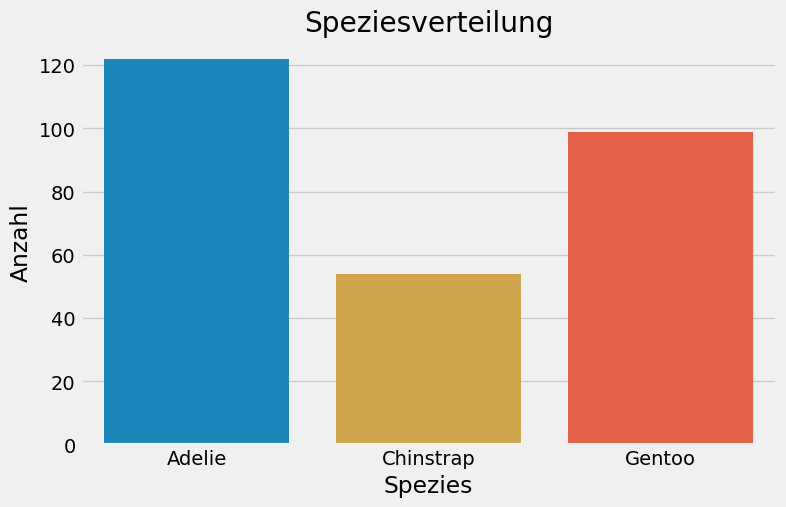

In [190]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='species', hue='species', hue_order=SPECIES_ORDER, palette=SPECIES_PALETTE)
plt.title('Speziesverteilung')
plt.xlabel('Spezies')
plt.ylabel('Anzahl')
plt.show()

Die Klassen sind leicht ungleich verteilt. Grundsätzlich könnte man hier Oversampling Verfahren wie RandomOverSampler oder SMOTE aus dem Package imbalanced-learn einsetzen, um dieses Ungleichgewicht auszugleichen. Solche Methoden bringen jedoch eigene Herausforderungen mit sich. Deshalb erscheint es sinnvoll, zunächst ohne Oversampling weiterzuarbeiten und diese Verfahren erst dann einzusetzen, wenn sich das Klassenungleichgewicht tatsächlich als relevantes Problem in der Modellperformance zeigt.

## Fehlende Werte

In [191]:
show_missing_values(df)

Wir sehen, dass für alle vier numerischen Messungen jeweils 2 Werte fehlen. Eine wichtige Frage ist dabei, ob diese fehlenden Werte zu denselben Datenpunkten gehören. Zusätzlich fehlen 11 Werte für das Feature `sex`.

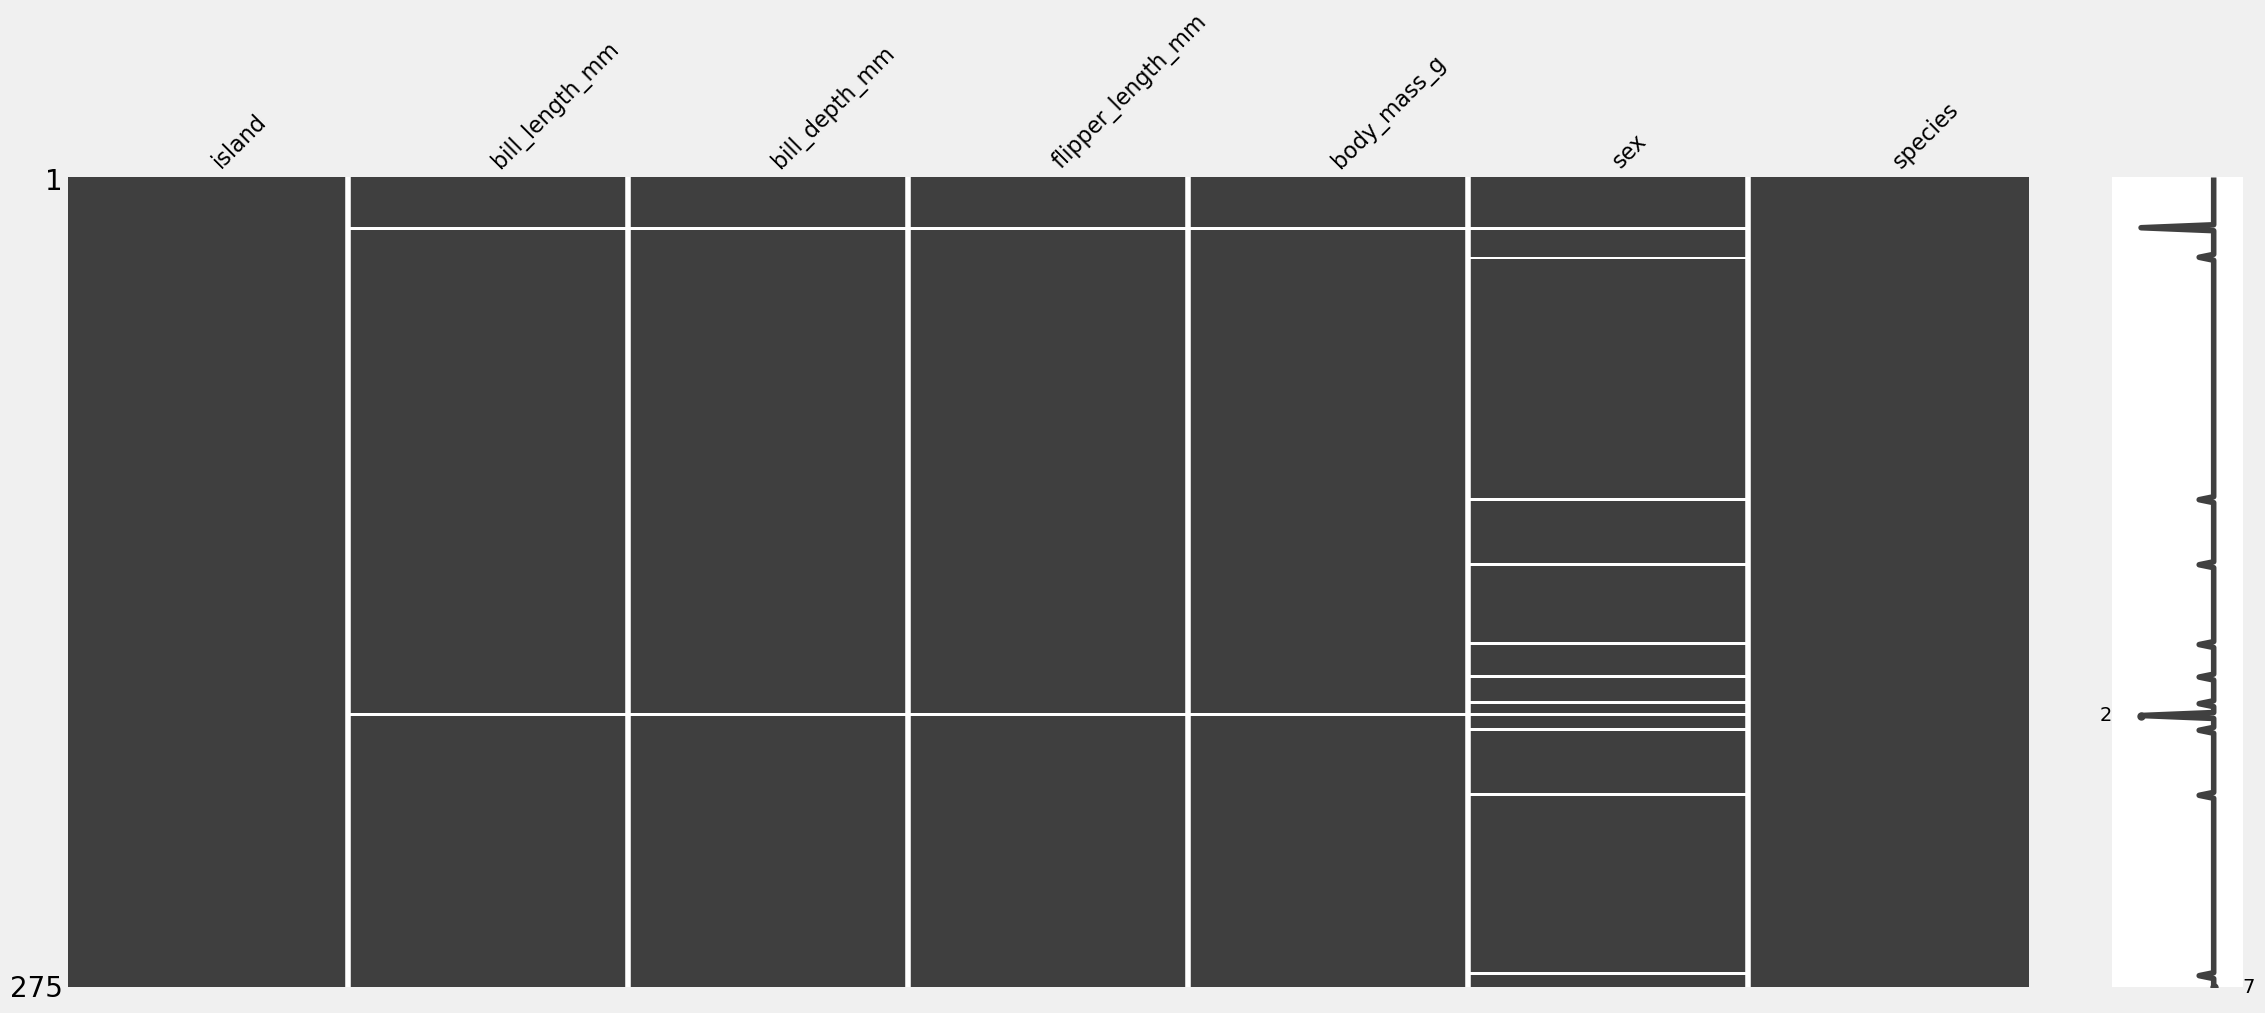

In [192]:
msno.matrix(df);

Man sieht in der MSNO Matrix, dass bei denselben zwei Datenpunkten nicht nur alle vier numerischen Messungen fehlen, sondern auch das Geschlecht. Daher würde ich diese Datenpunkte einfach droppen.

In der Produktion und bei den Testdaten könnten ebenfalls fehlende Werte auftreten (das wissen wir zum jetzigen Zeitpunkt noch nicht). Solche Fälle ließen sich über eine *Fallback-Logik* abfangen. Fehlen alle Hauptfeatures, könnte das Modell direkt die *Majoritätsklasse* zurückgeben, in unserem Fall `Adelie`, was immerhin in 44.15% der Fälle korrekt wäre. Dabei ist es wichtig, diese Logik transparent gegenüber den Stakeholdern zu kommunizieren, damit klar ist, wie Entscheidungen im Hintergrund zustande kommen.

Alternativ könnte man in solchen Situationen bewusst eine Fehlermeldung ausgeben. Beide Ansätze vermeiden, dass durch Imputation potenziell unrealistische Werte ins Modell gelangen. In diesem Kontext ist es besser, für einzelne Datenpunkte keine Vorhersage zu liefern, als dem Modell künstliche Muster beizubringen, die in der Realität nicht existieren.

Hinweis:
Alternativ könnte man versuchen, anhand der Insel die bedingte Wahrscheinlichkeit für die Art zu schätzen oder im Preprocessing einen *KNNImputer* einsetzen, um fehlende Werte durch einigermaßen "realistische" Werte zu ersetzen. Da es sich aber nur um zwei Datenpunkte handelt (rund 0.727% des Datensatzes), lohnt sich dieser Aufwand praktisch nicht.

Jetzt fehlen nur noch Geschlecht Werte von 11 Datenpunkten, um die kümmern wir uns später.

## Visualisierungen

Wir versuchen zunächst, die Klassen komplett manuell und visuell zu trennen, um zu prüfen, ob überhaupt ein ML Modell notwendig ist. Dabei gehen wir zunächst davon aus, dass wir ML möglicherweise gar nicht brauchen.

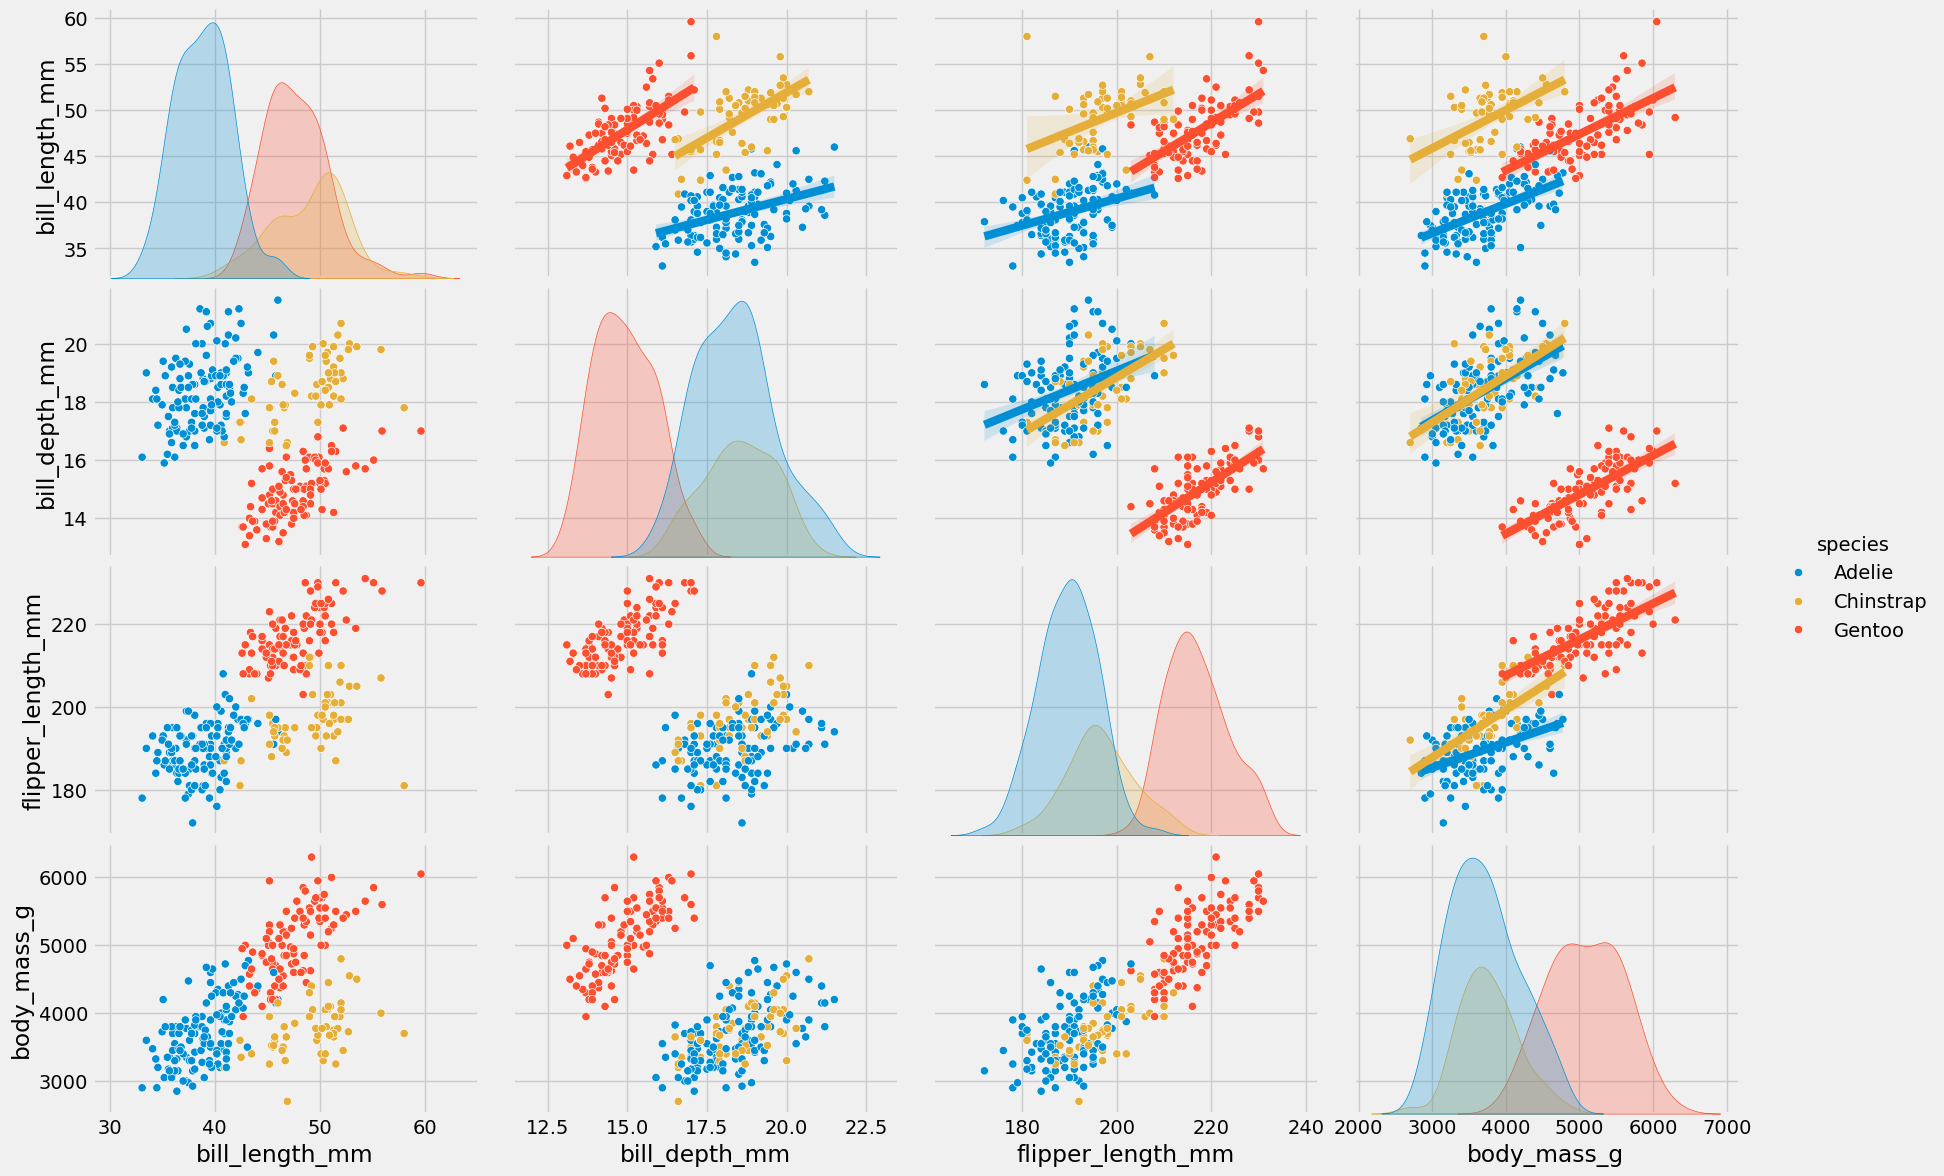

In [193]:
g = sns.pairplot(df, hue='species', diag_kind='kde', height=3, aspect=1.5, palette=SPECIES_PALETTE, hue_order=SPECIES_ORDER);
g.map_upper(sns.regplot, scatter=False);

Wir sehen, dass `bill_length_mm` allein schon eine ziemlich gute Trennung zwischen allen drei Arten ermöglicht. Bei den anderen Merkmalen, in denen keine `bill_length_mm` vorkommt, lässt sich zwar die Art `Gentoo` weiterhin gut unterscheiden, aber `Adelie` und `Chinstrap` überlappen stark.

Aus dieser Grafik können wir daher bereits vermuten, dass `bill_length_mm` ein besonders wichtiges Feature sein wird. Was wir an dieser Stelle jedoch noch nicht wissen, ist, mit welchen weiteren Merkmalen (`body_mass_g`, `flipper_length_mm`, `bill_depth_mm`) sich `bill_length_mm` am sinnvollsten kombinieren lässt, um eine möglichst robuste und generalisierbare Trennschärfe zu erreichen.

Auf der Hauptdiagonalen ist zu erkennen, dass die einzelnen Features innerhalb der jeweiligen Klassen 
näherungsweise normalverteilt sind.

Auch die kategorialen Variablen `sex` und `island` haben wir in dieser Darstellung noch nicht berücksichtigt.

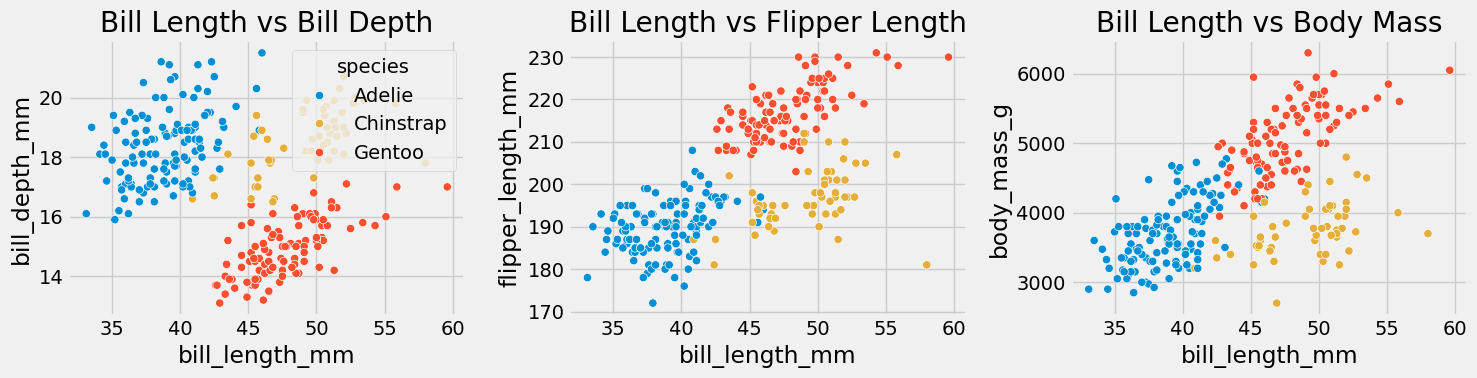

In [194]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
sns.scatterplot(data=df, x='bill_length_mm', y='bill_depth_mm', hue='species', ax=axes[0], palette=SPECIES_PALETTE, hue_order=SPECIES_ORDER);
axes[0].set_title('Bill Length vs Bill Depth');
sns.scatterplot(data=df, x='bill_length_mm', y='flipper_length_mm', hue='species', ax=axes[1], palette=SPECIES_PALETTE, hue_order=SPECIES_ORDER);
axes[1].set_title('Bill Length vs Flipper Length');
axes[1].legend_.remove();
sns.scatterplot(data=df, x='bill_length_mm', y='body_mass_g', hue='species', ax=axes[2], palette=SPECIES_PALETTE, hue_order=SPECIES_ORDER);
axes[2].set_title('Bill Length vs Body Mass');
axes[2].legend_.remove();
plt.tight_layout();
plt.show()

`bill_length_mm` hier nochmal genauer angeschaut.

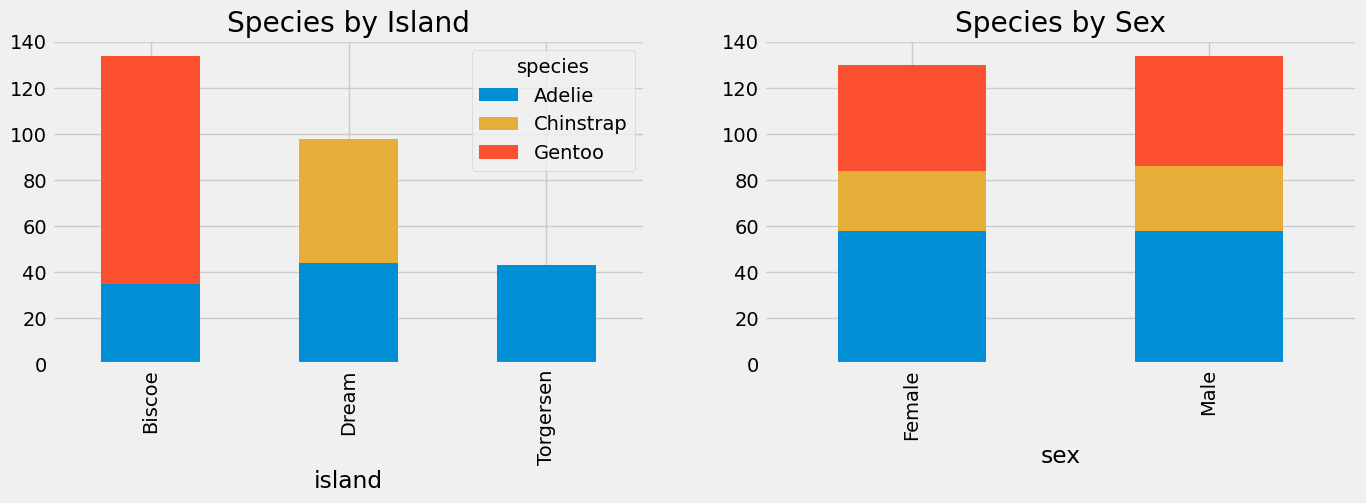

In [195]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
ct_island = pd.crosstab(df["island"], df["species"]).reindex(columns=SPECIES_ORDER)
ct_sex = pd.crosstab(df["sex"], df["species"]).reindex(columns=SPECIES_ORDER)
ax = ct_island.plot.bar(
    stacked=True,
    color=[SPECIES_PALETTE[s] for s in SPECIES_ORDER],
    ax=axes[0]
)
ax.set_title("Species by Island")
ax = ct_sex.plot.bar(
    stacked=True,
    color=[SPECIES_PALETTE[s] for s in SPECIES_ORDER],
    ax=axes[1],
    legend=False
)
ax.set_title("Species by Sex")
plt.show()

**Grafik links**  
Bisher fehlte uns ein Überblick über die kategorialen Features `island` und `sex`.  
In der linken Grafik sieht man bereits einige interessante Muster für `island`. In unserer Stichprobe:

- Auf der Insel `biscoe` kommt *keine* `Chinstrap` vor  
  →  $\text{Biscoe} \Rightarrow \neg \text{Chinstrap}$
- Auf der Insel `dream` kommt *keine* `Gentoo` vor  
  →  $\text{Dream} \Rightarrow \neg \text{Gentoo}$
- Auf der Insel `torgersen` findet man *nur* `Adelie`  
  →  $\text{Torgersen} \Rightarrow \text{Adelie}$

**Wichtig:**  
Hier darf man keinen logischen Umkehrschluss ziehen.
Die Aussagen oben heißen *nicht*, dass man aus der Insel auf die Art schließen könnte:

- `Adelie` kommt auf **allen** Inseln vor, also kann man sie nicht anhand der Insel vorhersagen.  
- `Chinstrap` und `Gentoo` treten zwar jeweils nur auf einer Insel auf, aber dort gibt es **auch** `Adelie`.  

Man kann also auch sie nicht eindeutig bestimmen.

Kurz gesagt: Nur wenn `island = torgersen`, wissen wir (fast) sicher, dass die Art `Adelie` ist. 
Dabei ist zu beachten, dass wir natürlich die Vorhersage *von* `island` *auf* `species` betrachten und nicht andersrum.

Hochstens ist diese Variable sehr nutzlich aussieht aber wir wissen noch nicht wie sie sich zusammen mit den anderen Variablen verhält.

**Anmerkung**: Die Aussagekraft des Features `island` hängt davon ab, wie die Daten erhoben wurden. Wenn man davon ausgeht, dass auf jeder Insel zufällig und nicht nur an einzelnen, lokalen Stellen gemessen wurde, dann ist es plausibel, dass eine Art, die auf einer Insel selten oder gar nicht beobachtet wird, dort auch tatsächlich selten oder nicht vorhanden ist. In diesem Fall trägt `island` reale Information über die Art (`species`) und ist kein zufälliges oder künstliches Merkmal.

Trifft diese Annahme nicht zu und die Messungen wurden nur sehr lokal durchgeführt, könnte das beobachtete Artvorkommen eher ein Artefakt der Datenerhebung sein. Dann würde `island` weniger biologische Information liefern, sondern vor allem widerspiegeln, wo gemessen wurde.

Da sich aus den verfügbaren Informationen nicht eindeutig klären lässt, welche dieser Annahmen zutrifft, gehe ich im Folgenden von der ersten Annahme aus.

**Grafik rechts**  
Bei der Variable `sex` fällt auf, dass in dieser Stichprobe die Verteilungen für alle Arten ungefähr **gleich** sind. Jede Art hat **ungefähr** dieselbe Anzahl an männlichen und weiblichen Vögeln. Das bedeutet, dass `sex` **keine Information** zur Vorhersage von `species` enthält. Das werden wir uns später einmal in dem Cramers V Matrix anschauen. 

$$ \Rightarrow P(\text{species} | \text{sex}) \approx P(\text{species})$$

Aber Achtung nur weil die Variable kein direktes Zusammenhang mit der Zielvariable hat, heißt es nicht, dass er auch die anderen Variablen nicht bei der Vorhersage helfen kann, wir haben also noch nicht ihre Zusammenhang mit anderen Features geprüft, deshalb lassen wir sie vorerst im Datensatz.

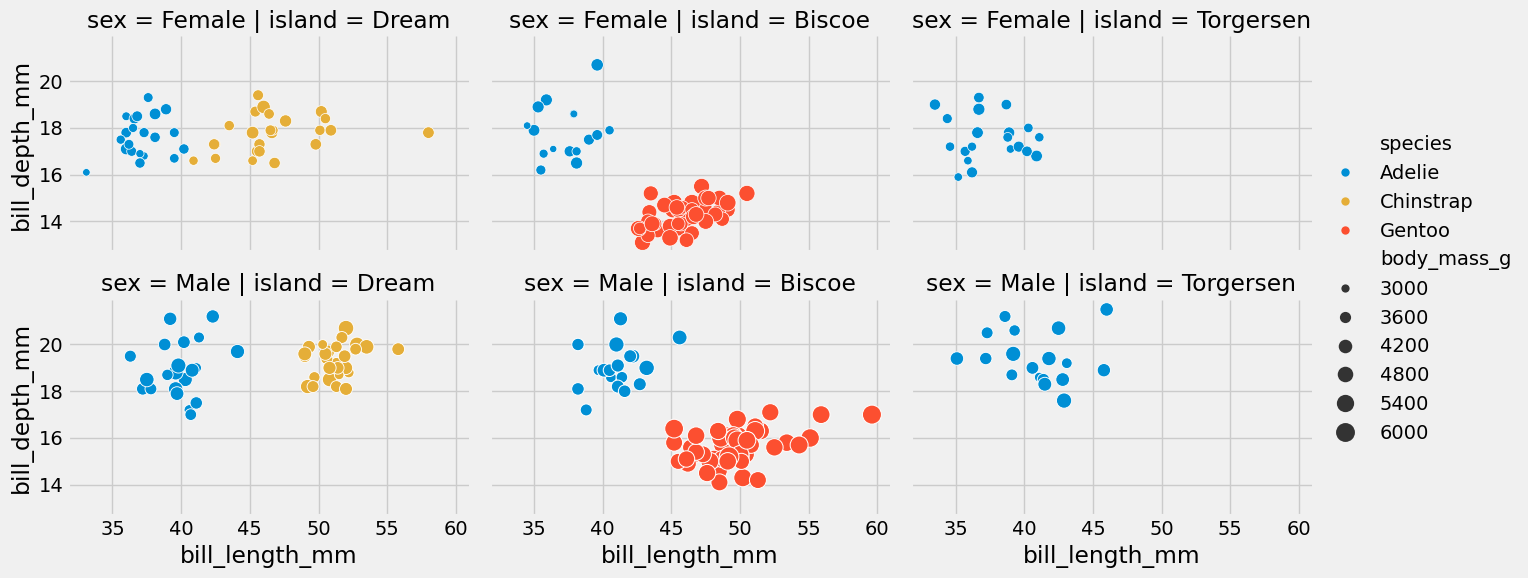

In [196]:
sns.relplot(x='bill_length_mm', 
            y='bill_depth_mm', 
            data=df, 
            hue='species', 
            col='island', 
            height=3, 
            aspect=1.5, 
            size='body_mass_g',
            row='sex',
            sizes=(20, 200),
            palette=SPECIES_PALETTE,
            hue_order=SPECIES_ORDER);

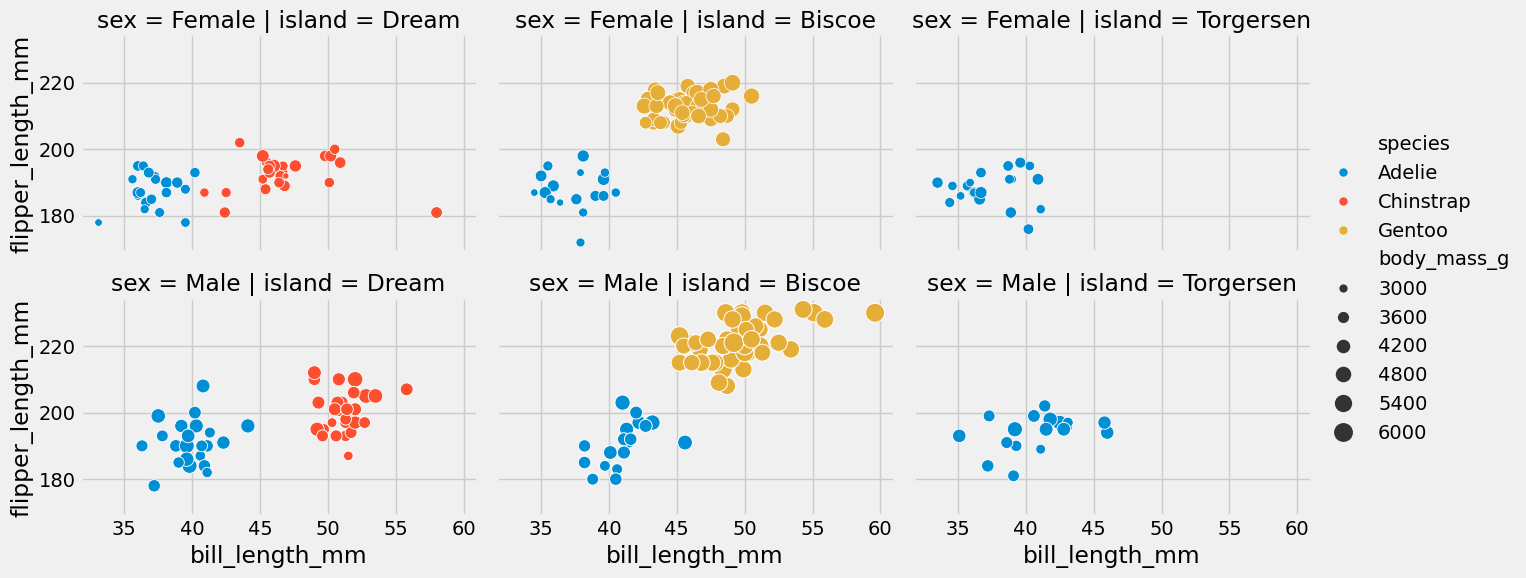

In [197]:
sns.relplot(x='bill_length_mm', 
            y='flipper_length_mm', 
            data=df, 
            hue='species', 
            col='island', 
            height=3, 
            aspect=1.5, 
            size='body_mass_g',
            row='sex',
            sizes=(20, 200));

In dieser Visualisierung lassen sich insgesamt sechs Dimensionen gleichzeitig darstellen:

• `sex` in den Zeilen  
• `island` in den Spalten  
• `bill_length_mm` auf der x-Achse  
• `bill_depth_mm` bzw. `flipper_length_mm` auf der y-Achse  
• `body_mass_g` über die Punktgröße  
• `species` über die Farbe  

Bereits auf den ersten Blick wird deutlich, dass `sex` praktisch keine zusätzliche Aussagekraft besitzt, selbst in Kombination mit mehreren anderen Variablen. Auch ein klarer Einfluss von `body_mass_g` lässt sich in diesen Plots kaum erkennen.

In diesen beiden Grafiken sind damit alle relevanten Features gemeinsam sichtbar. Es zeigt sich, dass in Anwesenheit von `bill_length_mm` und `bill_depth_mm` bzw. `flipper_length_mm` weder `sex` noch `body_mass_g` einen nennenswerten zusätzlichen Beitrag leisten. Wir lassen daher die beiden Variable weg und müssen uns nicht *mehr* um die fehlenden Werte in `sex` kümmern.

Für `island` ist die Situation weniger eindeutig: Zwar scheint ein Zusammenhang mit der Zielvariable zu bestehen, es bleibt jedoch offen, wie stark dieses Feature im Vergleich zu den morphologischen Merkmalen tatsächlich beiträgt.

Als potenzielle Features verbleiben daher `bill_length_mm`, `bill_depth_mm`, `flipper_length_mm` und `island`. Diese Merkmale erscheinen ausreichend, um die Klassifikation abzubilden. Welche davon letztlich verwendet werden und in welcher Kombination, wird im weiteren Verlauf entschieden.

In [198]:
# generiert von ChatGPT (Stand: 2025-12)

fig = px.scatter_3d(
    df,
    x='bill_length_mm',
    y='bill_depth_mm',
    z='flipper_length_mm',
    color='species',
    size=df['island'].astype('category').cat.codes + 1,
    symbol='island',
    category_orders={'species': SPECIES_ORDER},
    color_discrete_map=SPECIES_PALETTE,
)
fig.show()

In [199]:
# unkommentiere die folgende Zeile, um die 3D-Grafik als HTML-Datei zu speichern
# fig.write_html("figs/scatter_3d_morphology.html")

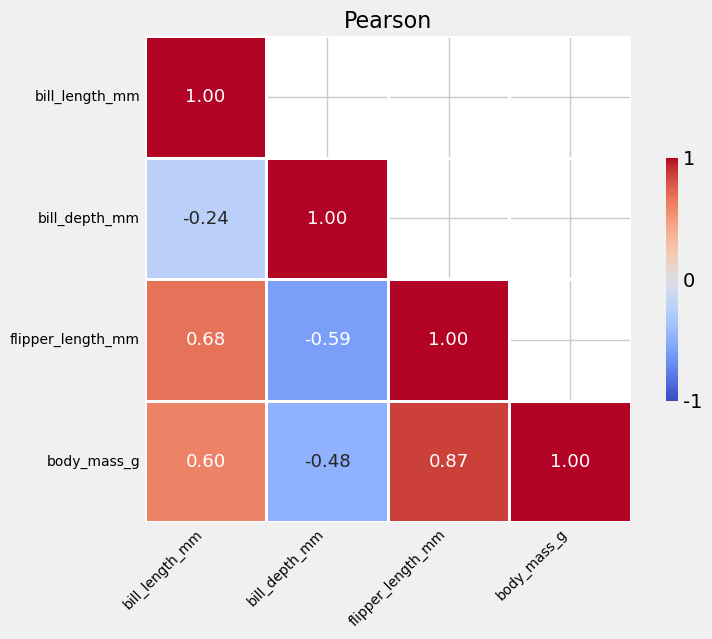

In [200]:
num_corr_heatmap(df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']].corr())

Als Nächstes betrachten wir die Pearson Korrelationsmatrix der numerischen Features. Dabei wird schnell deutlich, warum `body_mass_g` in Anwesenheit anderer Merkmale kaum zusätzliche Vorhersagekraft liefert: Das Feature ist sehr stark mit `flipper_length_mm` korreliert und zeigt zudem eine deutliche Korrelation mit `bill_length_mm`. Unter diesen Umständen ist nicht zu erwarten, dass `body_mass_g` im Zusammenspiel mit diesen beiden Features noch wesentlich neue Informationen beisteuert.

Interessant ist außerdem die Korrelation zwischen `flipper_length_mm` und `bill_length_mm`, die moderat bis stark ausfällt. Das deutet darauf hin, dass beide Merkmale teilweise ähnliche Informationen tragen und gemeinsam nicht zwingend deutlich mehr beitragen als jeweils einzeln. Vor diesem Hintergrund erscheint die Kombination aus `bill_length_mm` und `bill_depth_mm` besonders sinnvoll, wenn eine Entscheidung auf nur zwei Features beschränkt werden muss.

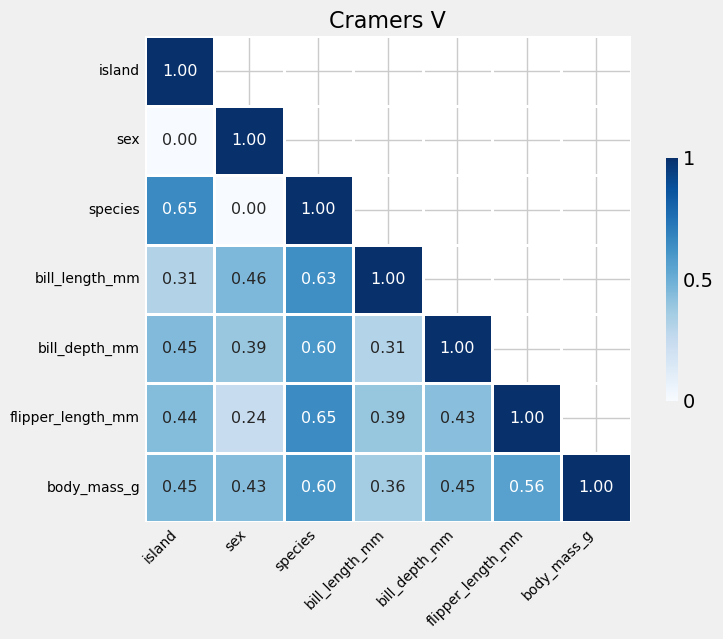

In [201]:
cramers_v = cramers_v_matrix(df)
cat_corr_heatmap(cramers_v);

In der Cramers V Matrix wird deutlich, dass `sex` kaum Zusammenhang mit der Zielvariable zeigt, was wir bereits in der vorherigen Analyse vermutet hatten.

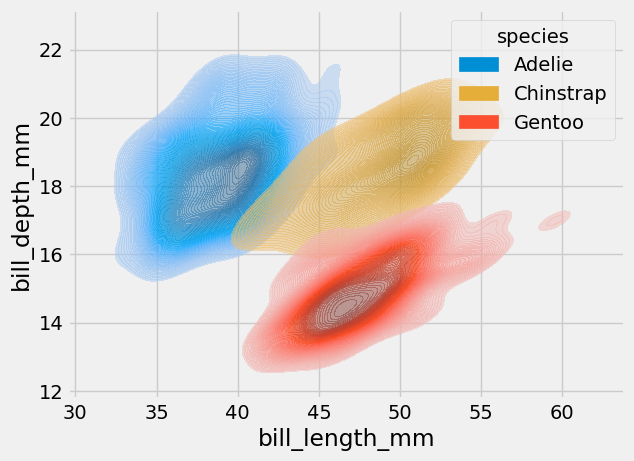

In [202]:
sns.kdeplot(
    data=df,
    x='bill_length_mm',
    y='bill_depth_mm',
    hue='species',
    fill=True,
    alpha=0.5,
    thresh=0.05,
    levels=100,
    palette=SPECIES_PALETTE,
    hue_order=SPECIES_ORDER
);

Von KDE Plot sieht es so aus, als wären die Features sogar zusammen Bivariate Normalverteilt sind.

In [203]:
# generiert von ChatGPT (Stand: 2025-12)

x = df['bill_length_mm'].dropna()
y = df['bill_depth_mm'].dropna()

kde = gaussian_kde([x, y])

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
zz = kde(positions).reshape(xx.shape)

fig = go.Figure(data=[
    go.Surface(
        x=xx,
        y=yy,
        z=zz,
        colorscale="Viridis"
    )
])

fig.update_layout(
    title="3D KDE Surface der Verteilung",
    scene=dict(
        xaxis_title="bill_length_mm",
        yaxis_title="bill_depth_mm",
        zaxis_title="density"
    ),
    height=600
)

fig.show()

Gegeben der Klasse sehen die Features bivariate Normalverteilt aus.

In [204]:
# unkommentiere die folgende Zeile, um die 3D-Grafik als HTML-Datei zu speichern
# fig.write_html("figs/kde_3d_surface.html")

## Feature Engineering

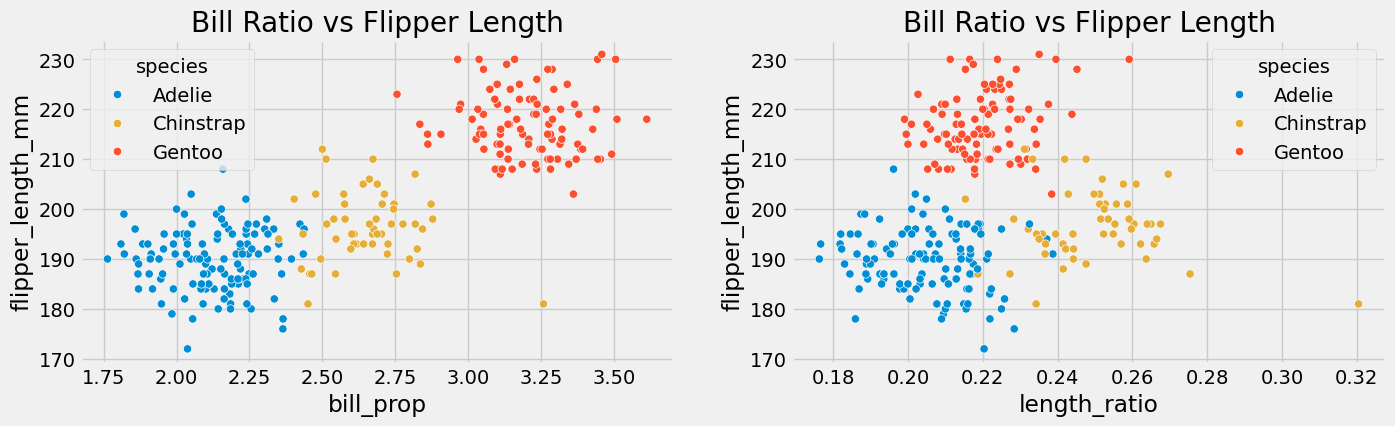

In [205]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

sns.scatterplot(
    data=df.assign(bill_prop=(df['bill_length_mm'] / df['bill_depth_mm'])),
    x='bill_prop',
    y='flipper_length_mm',
    hue='species',
    ax=axes[0],
    palette=SPECIES_PALETTE,
    hue_order=SPECIES_ORDER
)
axes[0].set_title('Bill Ratio vs Flipper Length')

sns.scatterplot(
    data=df.assign(length_ratio=(df['bill_length_mm'] / df['flipper_length_mm'])),
    x='length_ratio',
    y='flipper_length_mm',
    hue='species',
    ax=axes[1],
    palette=SPECIES_PALETTE,
    hue_order=SPECIES_ORDER
)
axes[1].set_title('Bill Ratio vs Flipper Length')
plt.show()

Ich habe außerdem zwei neue Features erzeugt: `bill_prop` (Verhältnis von Schnabellänge zu Schnabeltiefe) und `length_ratio` (Verhältnis von Schnabellänge zu Flipperlänge). Diese habe ich gemeinsam mit dem verbleibenden 3. Feature geplottet, um zu prüfen, ob sich die Klassen besser trennen lassen. Eine klare Verbesserung ist dabei jedoch nicht zu erkennen. Das deutet darauf hin, dass die neuen Features zwar inhaltlich sinnvoll erscheinen, aber keine zusätzlichen Informationen gegenüber den bestehenden Merkmalen liefern.

## Outliers

In [206]:
show_outliers(df.bill_depth_mm), show_outliers(df.flipper_length_mm)

(Series([], Name: bill_depth_mm, dtype: float64),
 Series([], Name: flipper_length_mm, dtype: float64))

Es gibt keine auffälligen Ausreißer in den Daten.

# Modellierung

## GNB

Der Gaussian Naive Bayes (GNB) Klassifikator kann in dieser Anwendung sinnvoll eingesetzt werden, aus mehreren Gründen:

1. Die verwendeten Features sind stetig  
2. Die Feature Verteilungen gegeben der Klasse sind näherungsweise normalverteilt  
3. Es handelt sich um ein White Box Modell, das transparent, leicht interpretierbar und in der Praxis einfach anzuwenden ist  
4. Das Modell basiert auf soliden theoretischen Grundlagen aus der Wahrscheinlichkeitstheorie  
5. Die Inferenz ist sehr schnell und effizient  

Gleichzeitig besitzt Gaussian Naive Bayes auch einen zentralen Nachteil:

1. Es wird die naive Annahme getroffen, dass die Features gegeben der Klasse unabhängig voneinander sind

Zunächst verwenden wir die beiden Features `bill_length_mm` und `bill_depth_mm`, da sie sich in der explorativen Datenanalyse als besonders geeignet erwiesen haben.

In [207]:
X, y = pipeline(df, features=['bill_length_mm', 'bill_depth_mm'])

In [208]:
gnb = GaussianNB(priors=[1/3, 1/3, 1/3])
cv = loocv(gnb, X, y, metrics=['accuracy'], train_score=True)
print_cv(cv)

test_accuracy: 0.9414 ± 0.2349
train_accuracy: 0.9450 ± 0.0007


Wir setzen ein a-priori von 1/3 an, das heißt, wir nehmen an, dass alle drei Klassen gleich wahrscheinlich sind, unabhängig von ihrer Häufigkeit im Datensatz. Die zugrunde liegende Annahme ist dabei, dass eine größere Anzahl an Messungen für eine bestimmte Art im Datensatz nicht zwangsläufig bedeutet, dass diese Art auch in der Realität häufiger vorkommt.

Für die Evaluation verwende ich Leave-One-Out Kreuz Validierung (LOOCV), da der Datensatz insgesamt relativ klein ist und LOOCV in diesem Fall einen sehr genauen Schätzer für die Generalisierungsleistung liefert. Die Accuracy auf den Trainingsdaten und in der LOOCV-Validierung ist nahezu identisch und insgesamt relativ hoch. Gleichzeitig zeigt sich eine vergleichsweise hohe Standardabweichung der Validierungs-Accuracy.

Daraus lassen sich folgende Schlüsse ziehen:

- Gaussian Naive Bayes passt gut zu den Daten  
- Das Modell generalisiert stabil und zeigt kein starkes Overfitting  
- Damit eignet sich GNB nicht nur als solides Basismodell, sondern hat grundsätzlich auch das Potenzial, in der Praxis eingesetzt zu werden  

**Anmerkung zur Evaluation:**  
Im LOOCV besteht das Testset in jedem Split aus genau einem Sample (Singleton) , und [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) berechnet den gewählten Score mit `cross_val_score` **pro Split** und gibt ein Array dieser Split-Scores zurück . Dadurch ist die Accuracy je Split zwangsläufig binär (1 bei korrekter Vorhersage, sonst 0), da `accuracy_score` die Fraktion korrekt klassifizierter Samples misst . Für `scoring="f1_macro"` verwendet scikit-learn den macro-averaged F1-Score (ungewichtetes Mittel der label-spezifischen F1-Werte)  und berücksichtigt bei `labels=None` standardmäßig nur Labels, die im jeweiligen Split in `y_true` oder `y_pred` vorkommen . Bei einem Singleton-Testfold ist das im korrekten Fall genau ein Label (F1-macro = 1) und im Fehlerfall genau zwei Labels, deren F1 jeweils 0 ist (F1-macro = 0), sodass F1-macro je Split exakt mit Accuracy übereinstimmt. Deshalb liefert `f1_macro` in diesem spezifischen LOOCV-Setup keine zusätzliche Information gegenüber Accuracy und wird hier nicht separat berichtet; abweichende Ergebnisse sind erst zu erwarten, wenn z. B. Labels explizit erzwungen werden oder F1 global über alle Out-of-fold Predictions berechnet wird .

In [209]:
df_cv = pd.DataFrame({
    "accuracy_train": cv["train_accuracy"],
    "accuracy_test": cv["test_accuracy"],
})
df_cv.head()

accuracy_train  accuracy_test
0        0.944853            1.0
1        0.944853            1.0
2        0.944853            1.0
3        0.944853            1.0
4        0.944853            1.0

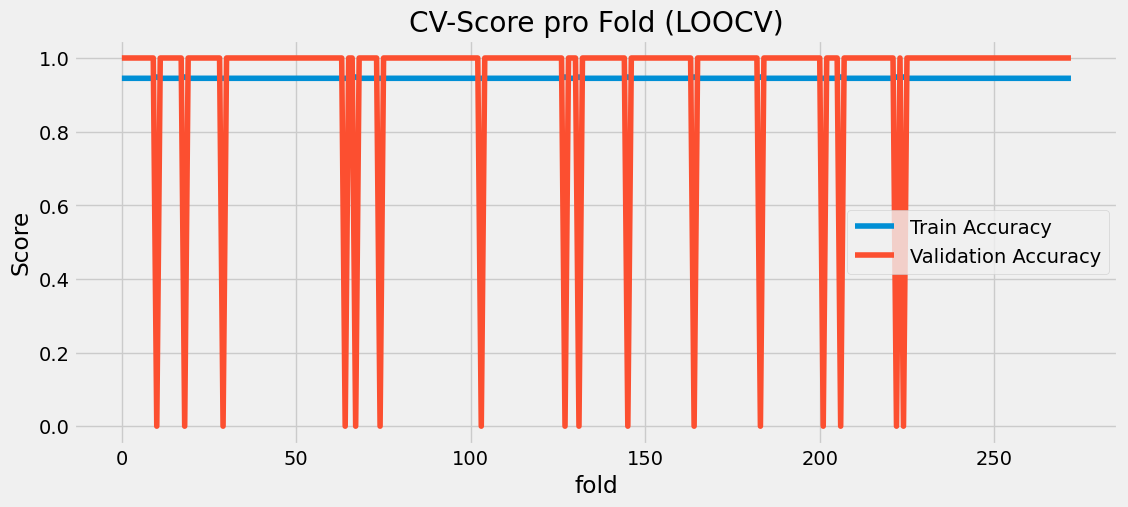

In [210]:
df_cv["fold"] = df_cv.index

plt.figure(figsize=(12,5))
sns.lineplot(data=df_cv, x="fold", y="accuracy_train", label="Train Accuracy")
sns.lineplot(data=df_cv, x="fold", y="accuracy_test", label="Validation Accuracy")
plt.title("CV-Score pro Fold (LOOCV)")
plt.ylabel("Score")
plt.show()

Hier zeigt sich genau das gleiche Bild: Die Trainings Accuracy bleibt stabil, während die Validation Accuracy zwischen 1 und 0 schwankt. Dabei handelt es sich nicht um einen Bug, sondern um einen typischen Nebeneffekt von LOOCV, da in jedem Validation Fold genau ein einzelner Datenpunkt bewertet wird.

In [211]:
X, y = pipeline(df, features=['bill_length_mm', 'bill_depth_mm'])

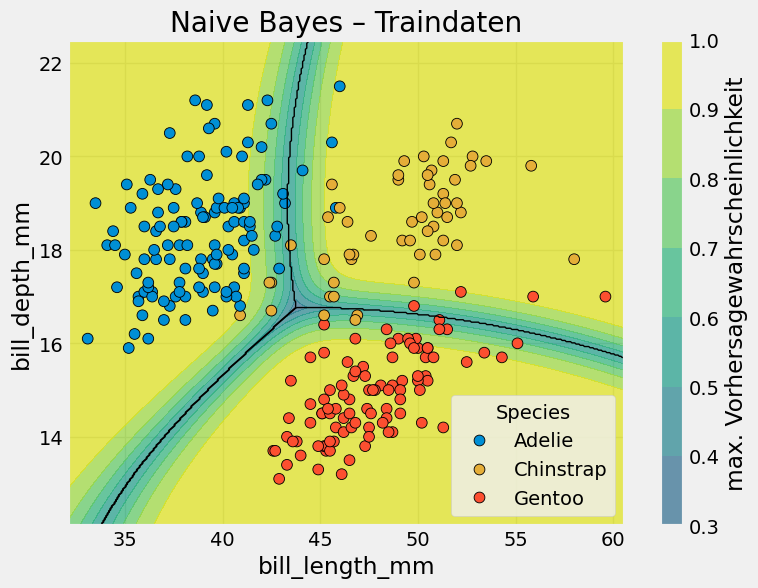

In [212]:
# generiert von ChatGPT (Stand: 2025-12)

cont, ax = plot_decision_boundary(
    X, y,
    model=gnb,
    model_name="Naive Bayes",
    which_points="train",
    manual=False,
    class_order=SPECIES_ORDER,
    palette=SPECIES_PALETTE
)

fig = ax.get_figure()
fig.colorbar(cont, ax=ax, label="max. Vorhersagewahrscheinlichkeit")
plt.show()

Hier ist die Entscheidungsgrenze des NB Modells inklusive Wahrscheinlichkeitskala dargestellt. Dabei sehen wir, dass Punkte, die weit von der Entscheidungsgrenze entfernt liegen, sehr eindeutig klassifiziert werden. Unsicherheiten treten fast ausschließlich in der Nähe der Entscheidungsgrenze auf.

Außerdem sehen wir, dass die Klasse `Chinstrap` teilweise mit den anderen Klassen überlappt. Besonders auffällig ist der Bereich etwa bei (`bill_length_mm` ≈ 55–60, `bill_depth_mm` ≈ 17–18). In diesem Bereich weist das Modell eine sehr hohe Vorhersagewahrscheinlichkeit für `Chinstrap` auf, teilweise nahe 1, obwohl dort vereinzelt sogar mehr Datenpunkte der Klasse `Gentoo` vorkommen.

Dieses Verhalten ist typisch für GNB. Da für jede Klasse eine Normalverteilung angenommen wird, erhalten Punkte, die weit vom jeweiligen Klassenmittelwert entfernt liegen, eine sehr geringe Wahrscheinlichkeit. Die in diesem Bereich liegenden `Gentoo` Punkte werden daher vom Modell praktisch ignoriert, da es unter der getroffenen Verteilungsannahme als sehr unwahrscheinlich gilt, dass ein `Gentoo` in diesem Bereich auftritt.

test_accuracy: 0.9454 ± 0.0371
test_f1_macro: 0.9292 ± 0.0499
test_precision_macro: 0.9373 ± 0.0452
test_recall_macro: 0.9304 ± 0.0550


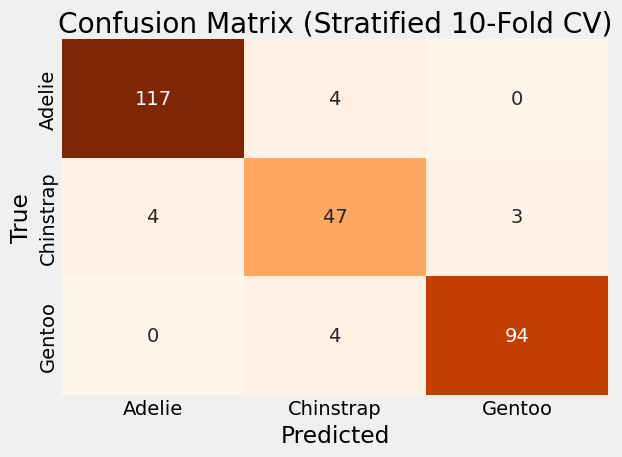

In [213]:
k = 10
cv = skfcv(gnb, X, y, random_seed=RANDOM_SEED, k=k)
print_cv(cv["cv"])
plot_confusion_matrix(cv["cm"], classes=np.unique(y), title=f'Confusion Matrix (Stratified {k}-Fold CV)')

Da wir mit LOOCV kein detailliertes klassenweises Modellverhalten analysieren können, sondern im Wesentlichen nur die Accuracy betrachten (dafür jedoch sehr präzise), führen wir zusätzlich eine stratifizierte Kreuzvalidierung durch. Dadurch ist es möglich, Precision, Recall sowie die Konfusionsmatrix sinnvoll auszuwerten.

Precision und Recall liegen dabei sehr nahe beieinander. Das deutet darauf hin, dass das Modell keinen systematischen Bias in Richtung falsch positiver oder falsch negativer Vorhersagen aufweist. In der Konfusionsmatrix zeigt sich das gleiche Muster, das bereits in der Visualisierung der Entscheidungsgrenze zu erkennen war: Die Klasse `Chinstrap` ist für das Modell am schwierigsten zu unterscheiden und wird häufiger mit den anderen Klassen verwechselt. Dagegen hat das Modell kaum Probleme, `Gentoo` und `Adelie` voneinander zu trennen.

## kNN

Für ein Klassifikationsproblem mit wenigen numerischen Features ist es sinnvoll, kNN auszuprobieren. Obwohl das Modell sehr einfach ist, funktioniert es in vielen Fällen erstaunlich gut und kann mit deutlich komplexeren Modellen konkurrieren.

kNN macht dabei durchaus eine Annahme: Es geht davon aus, dass Datenpunkte mit dem gleichen Label im Feature Raum nah beieinander liegen. Anders gesagt: Ähnliche Features führen zu ähnlichen Labels. Damit diese Annahme Sinn ergibt, müssen Abstände zwischen Punkten aussagekräftig sein, weshalb eine sinnvolle Skalierung der Features wichtig ist.

Ein klarer Nachteil von kNN ist, dass es in höheren Dimensionen schlecht funktioniert (Curse of Dimensionality). In unserem Fall spielt das jedoch keine große Rolle, da wir nur mit wenigen Features arbeiten.

In [214]:
df.head()

island  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
98       Dream            33.1           16.1              178.0       2900.0   
114     Biscoe            39.6           20.7              191.0       3900.0   
118  Torgersen            35.7           17.0              189.0       3350.0   
303     Biscoe            50.0           15.9              224.0       5350.0   
343     Biscoe            49.9           16.1              213.0       5400.0   

        sex species  
98   Female  Adelie  
114  Female  Adelie  
118  Female  Adelie  
303    Male  Gentoo  
343    Male  Gentoo

In [215]:
features = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']

knn = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=3))
])

Wir nehmen zunächst die drei potenziellen Features `bill_length_mm`, `bill_depth_mm` und `flipper_length_mm`. Diese skalieren wir mit `StandardScaler()` (Standardisierung auf 0 Mittelwert und 1 Standardabweichung). Anschließend verwenden wir zunächst k = 3 Nachbarn (willkürlich gewählt), um die Pipeline aufzubauen.

In [216]:
X, y = pipeline(df, features=features)
accuracy_scores_train = []
accuracy_scores_test = []
f1_scores_train = []
f1_scores_test = []
max_k = 50
k_neighbours = range(1, max_k + 1)
for k in k_neighbours:
    knn.set_params(clf__n_neighbors=k)
    cv = skfcv(knn, X, y, k=10, metrics=['accuracy', 'f1_macro'], train_score=True, random_seed=RANDOM_SEED, cm=False)['cv']
    accuracy_scores_train.append(np.mean(cv['train_accuracy']))
    accuracy_scores_test.append(np.mean(cv['test_accuracy']))
    f1_scores_train.append(np.mean(cv['train_f1_macro']))
    f1_scores_test.append(np.mean(cv['test_f1_macro']))

Hier führen wir eine stratifizierte Kreuzvalidierung für k zwischen 1 und 50 durch, um den optimalen Wert für k zu finden.

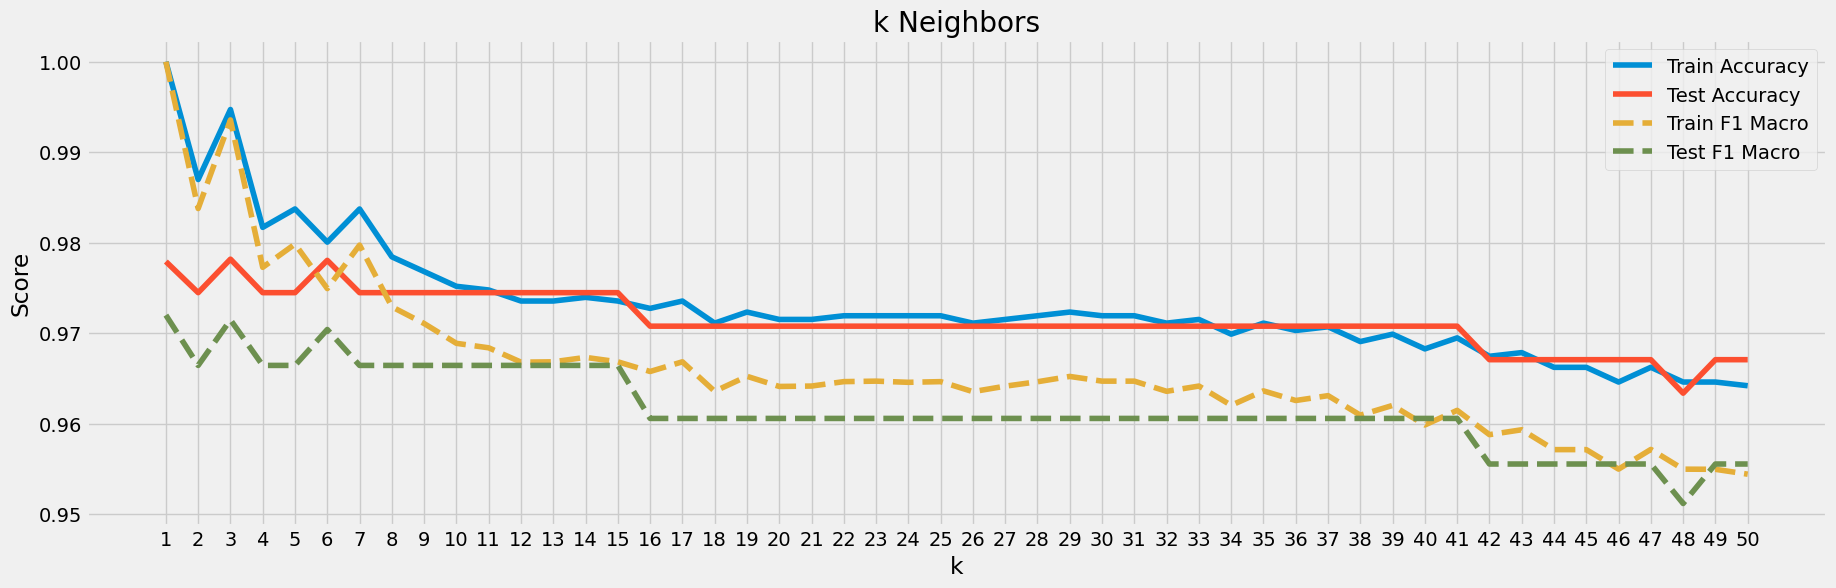

In [217]:
plt.figure(figsize=(20, 6))
plt.plot(k_neighbours, accuracy_scores_train, label='Train Accuracy')
plt.plot(k_neighbours, accuracy_scores_test, label='Test Accuracy')
plt.plot(k_neighbours, f1_scores_train, label='Train F1 Macro', linestyle='--')
plt.plot(k_neighbours, f1_scores_test, label='Test F1 Macro', linestyle='--')
plt.xticks(range(1, max_k + 1))
plt.xlabel('k')
plt.ylabel('Score')
plt.title('k Neighbors')
plt.legend()
plt.show()

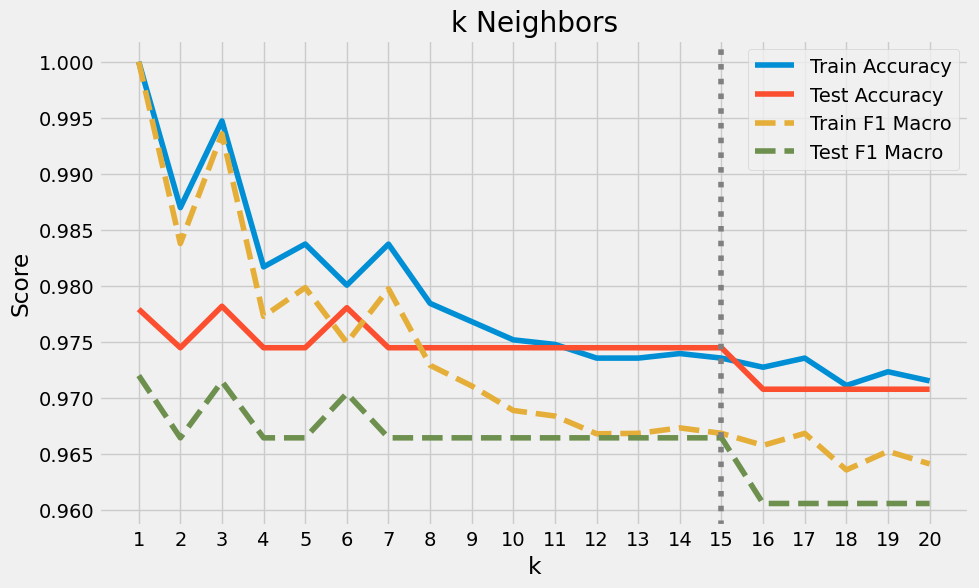

In [218]:
max_k = 20
plt.figure(figsize=(10, 6))
plt.plot(k_neighbours[:max_k], accuracy_scores_train[:max_k], label='Train Accuracy')
plt.plot(k_neighbours[:max_k], accuracy_scores_test[:max_k], label='Test Accuracy')
plt.plot(k_neighbours[:max_k], f1_scores_train[:max_k], label='Train F1 Macro', linestyle='--')
plt.plot(k_neighbours[:max_k], f1_scores_test[:max_k], label='Test F1 Macro', linestyle='--')
plt.axvline(x=15, color='gray', linestyle=':')
plt.xticks(range(1, max_k + 1))
plt.xlabel('k')
plt.ylabel('Score')
plt.title('k Neighbors')
plt.legend()
plt.show()

Die Test Accuracy bleibt im Bereich zwischen k = 7 und k = 15 relativ stabil. Man würde hier eher k = 15 wählen, da ein etwas größeres k in der Regel besser generalisiert.

*Allgemein* gilt für kNN: Je kleiner k ist, desto stärker passt sich das Modell an die Trainingsdaten an und desto höher ist die Gefahr von Overfitting. Mit größerem k wird das Modell glatter und stabiler, was meist zu besserer Generalisierung führt. Deshalb ist ein größeres k oft zu bevorzugen, solange das Modell dadurch nicht anfängt zu stark zu underfitten.

In [219]:
knn.set_params(clf__n_neighbors=15)
for feature_set in [['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'], ['bill_length_mm', 'bill_depth_mm'], ['bill_length_mm', 'flipper_length_mm']]:
    X, y = pipeline(df, features=feature_set)
    cv = loocv(knn, X, y, metrics=['accuracy'], train_score=True)
    print(f"Features: {feature_set}")
    print_cv(cv)

Features: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']
test_accuracy: 0.9744 ± 0.1581
train_accuracy: 0.9744 ± 0.0006
Features: ['bill_length_mm', 'bill_depth_mm']
test_accuracy: 0.9634 ± 0.1879
train_accuracy: 0.9669 ± 0.0009
Features: ['bill_length_mm', 'flipper_length_mm']
test_accuracy: 0.9524 ± 0.2130
train_accuracy: 0.9526 ± 0.0011


Jetzt schauen wir uns die LOOCV Performance von kNN für unterschiedliche Feature Mengen an, jeweils mit dem zuvor ausgewählten k. Dabei sieht man klar, dass die beste Performance mit allen drei Features erreicht wird und das Modell dabei auch gut generalisiert. Danach folgt die Kombination aus `bill_length_mm` und `bill_depth_mm`. Am schlechtesten schneidet die Kombination aus `bill_length_mm` und `flipper_length_mm` ab.

Die Entscheidung ist damit relativ eindeutig: Wenn die Priorität auf möglichst guter Vorhersage liegt, sollten alle drei Features verwendet werden. Wenn hingegen das Modellverhalten besser verstanden werden soll und dafür so wenige Features wie möglich genutzt werden sollen, ist die Teilmenge aus `bill_length_mm` und `bill_depth_mm` eine sinnvolle Wahl.

**Anmerkung:** Da ich k auf denselben Trainingsdaten auswähle, auf denen ich danach LOOCV berechne, können die Ergebnisse leicht optimistisch sein. Idealerweise würde man zuerst einen Train-Validation Split machen, innerhalb der Trainingsdaten per stratifizierter KV k auswählen und erst danach mit LOOCV die Modellperformance zur Feature-Auswahl anschauen.

Da kNN ein Black Box Modell ist, ist es sinnvoll, ein interpretierbares Verfahren zu verwenden, um das Verhalten der Features besser zu verstehen. In diesem Fall nutze ich SHAP, da das Verfahren modellagnostisch ist und sich daher gut mit kNN kombinieren lässt. Zudem erlaubt SHAP sowohl eine globale als auch eine lokale Analyse des Modellverhaltens.

Adelie


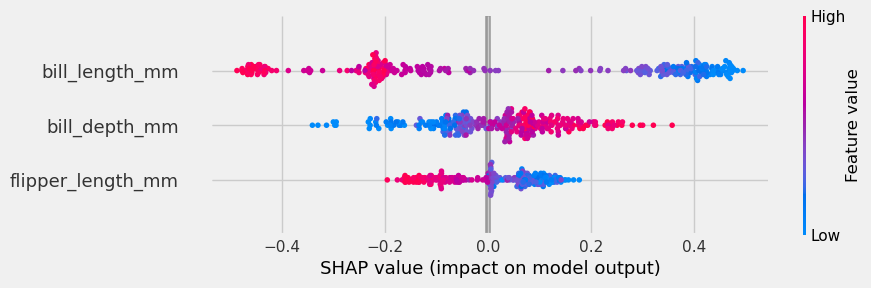

Chinstrap


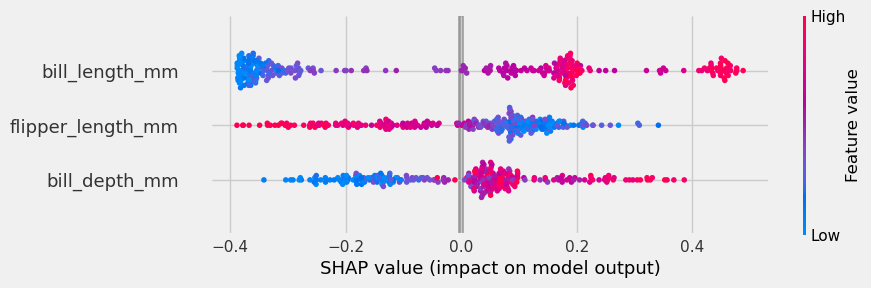

Gentoo


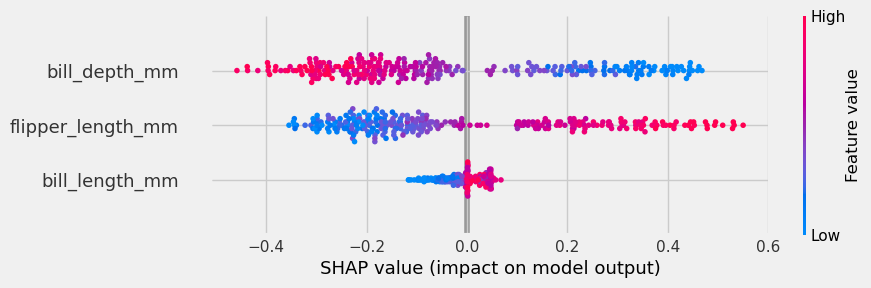

In [220]:
X, y = pipeline(df, features=['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'])
knn.fit(X, y)
exactexplainer = shap.ExactExplainer(knn.predict_proba, X, )
explainer = exactexplainer(X)
classes = np.unique(y)
print(f"{classes[0]}")
shap.plots.beeswarm(explainer[:, :, 0])
print(f"{classes[1]}")
shap.plots.beeswarm(explainer[:, :, 1])
print(f"{classes[2]}")
shap.plots.beeswarm(explainer[:, :, 2])

Hier sehen wir, dass die wichtigsten Features in allen drei Klassen entweder `bill_length_mm` oder `bill_depth_mm` sind, wenn wir das Modell mit allen drei Features verwenden. Das bestätigt unseren Eindruck aus der vorherigen Analyse, dass diese beiden Merkmale wichtiger sind als `flipper_length_mm`.

test_accuracy: 0.9636 ± 0.0360
test_f1_macro: 0.9506 ± 0.0478
test_precision_macro: 0.9689 ± 0.0369
test_recall_macro: 0.9417 ± 0.0536


<Figure size 800x600 with 0 Axes>

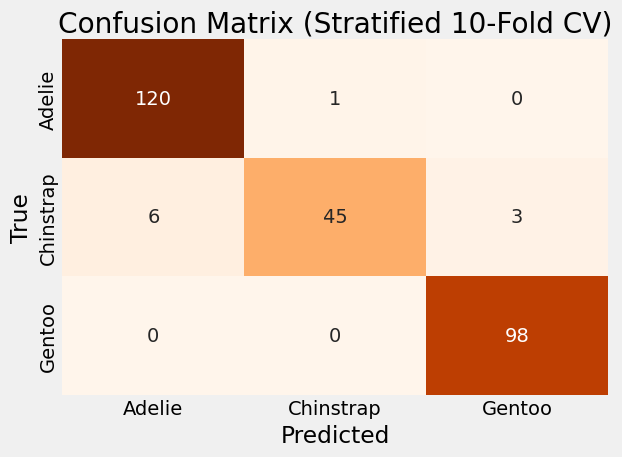

In [221]:
plt.figure(figsize=(8, 6))
k = 10
X, y = pipeline(df, features=['bill_length_mm', 'bill_depth_mm'])
cv = skfcv(knn, X, y, k=k, random_seed=RANDOM_SEED)
print_cv(cv['cv'])
plot_confusion_matrix(cv['cm'], classes=np.unique(y), title=f'Confusion Matrix (Stratified {k}-Fold CV)')
plt.show()

In der stratifizierten Kreuzvalidierung sieht man, dass das Modell insgesamt gut generalisiert. Die Validation Accuracy und die Precision sind sehr hoch, während der Recall etwas schlechter ausfällt. Das bedeutet, dass das Modell mehr False Negatives produziert.

Dieses Verhalten lässt sich sehr wahrscheinlich auf die Klasse `Chinstrap` zurückführen. Das Modell übersieht diese Klasse häufiger, als dass es sie fälschlicherweise erkennt. Konkret wurde `Chinstrap` 9 Mal übersehen und nur einmal falsch vorhergesagt. Aus der Analyse mit Naive Bayes wissen wir bereits, dass diese Klasse strukturell schwieriger zu unterscheiden ist, was unter anderem auch mit ihrem geringeren Vorkommen im Datensatz zusammenhängen kann (Klassenungleichgewicht).

Falls es besonders wichtig wäre, die Klasse `Chinstrap` nicht systematisch zu übersehen, ließe sich die Klassengewichtung in dem Modell entsprechend anpassen. Da kNN jedoch keine expliziten Klassengewichte unterstützt, müsste dieser Effekt über eine Gleichgewichtung der Klassen erzeugt werden, zum Beispiel durch Oversampling der `Chinstrap` Beobachtungen. Dadurch würden Precision und Recall tendenziell ausgeglichener, allerdings möglicherweise auf Kosten der Gesamtgenauigkeit und der Generalisierungsfähigkeit.

Da die aktuelle Priorität nicht auf der maximalen Erkennung von `Chinstrap` liegt, entscheide ich mich, mit dem bestehenden Modell unverändert weiterzuarbeiten.

In [222]:
X, y = pipeline(df, features=['bill_length_mm', 'bill_depth_mm'])
knn.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', KNeighborsClassifier(n_neighbors=15))])

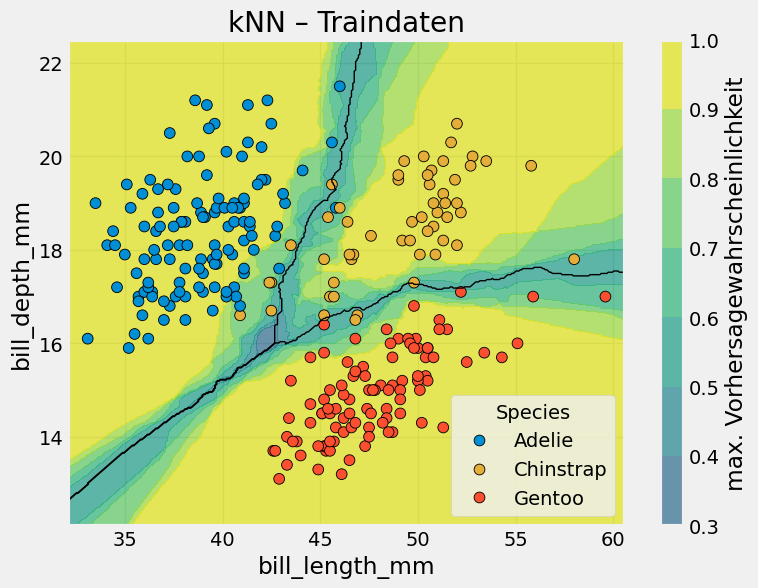

In [223]:
# generiert von ChatGPT (Stand: 2025-12)
fig, ax =plt.subplots(figsize=(8, 6))
cont, ax = plot_decision_boundary(
    X, y,
    model=knn,
    model_name="kNN",
    which_points="train",
    manual=False,
    class_order=SPECIES_ORDER,
    palette=SPECIES_PALETTE,
    ax=ax
)

fig = ax.get_figure()
fig.colorbar(cont, ax=ax, label="max. Vorhersagewahrscheinlichkeit")
plt.show()

Hier sehen wir die Entscheidungsgrenze des Modells. Sie ist nicht so glatt wie bei GNB, schneidet insgesamt aber besser ab. Besonders deutlich wird das in den Bereichen etwa bei ([52–60], [16–18]) und ([45–47], [20–22]). Diese Punkte wurden von GNB praktisch komplett ignoriert, während kNN sie zumindest berücksichtigt, wenn auch mit geringerer Sicherheit.

Gleichzeitig sehen wir, dass das bereits diskutierte Problem mit False Negatives für die Klasse `Chinstrap` bei kNN etwas stärker ausgeprägt ist als bei GNB.

## Entscheidungsbaum

Es wäre eine Sünde, bei einem Klassifikationsproblem keine baumbasierten Modelle anzuschauen. Da unser Problem insgesamt relativ einfach ist, entscheide ich mich hier für das einfachste baumbasierte Modell, nämlich einen CART basierten Entscheidungsbaum.

Entscheidungsbäume haben einige klare Vorteile: Sie sind sehr gut interpretierbar, leicht nachvollziehbar und erlauben eine schnelle Inferenz. Gleichzeitig bringen sie aber auch typische Nachteile mit sich. Ohne Regularisierung neigen sie stark zum Overfitting (hohe Varianz), sie trennen immer nur entlang einer einzelnen Variable und erzeugen dadurch achsenparallele Entscheidungsgrenzen, und sie sind gierig, das heißt, sie optimieren jeden Split lokal, was nicht zwangsläufig zu einer global optimalen Lösung führt.

In [224]:
dtc = DecisionTreeClassifier(
    random_state=RANDOM_SEED,
    criterion='gini', # ['gini', 'entropy'] 
    splitter='best', # ['best' -> bestes Feature + bester Schwellen, 'random' -> zufälliges Feature + bester Schwellen]
    max_depth=4,
    min_samples_split=2, # minimum ist 2
    min_samples_leaf=1, # minimum ist 1
    max_features=None, # Anzahl zufälliger Features, die bei einem Split berücksichtigt werden
    max_leaf_nodes=10 # maximale Anzahl an Blattknoten
)
dtc

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=10, random_state=42)

Ein Entsceidungsbaum kann immer 100% Genauigkeit erreichen, gegeben genug Freiheitsgeraden. Unser Ziel ist aber, die Lösung so einfach wie Möglich zu behalten. Deswegen beschränken wir den Baum bis zur Tiefe 4 und maximale Blätter 10, diese Entscheidung ist quasi unsere Obere Schranke für Komplexität, weil wenn er mit diesem Komplexitätsniveau mit den anderen Modellen nicht konkurrieren kann, dann sind die anderen Alternativen bereits besser.

In [225]:
for feature_set in [['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm'], ['bill_length_mm', 'bill_depth_mm'], ['bill_length_mm', 'flipper_length_mm']]:
    X, y = pipeline(df, features=feature_set)
    cv = loocv(dtc, X, y, metrics=['accuracy'], train_score=True)
    print(f"features: {feature_set}")
    print_cv(cv)

features: ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']
test_accuracy: 0.9634 ± 0.1879
train_accuracy: 0.9890 ± 0.0005
features: ['bill_length_mm', 'bill_depth_mm']
test_accuracy: 0.9707 ± 0.1687
train_accuracy: 0.9816 ± 0.0026
features: ['bill_length_mm', 'flipper_length_mm']
test_accuracy: 0.9414 ± 0.2349
train_accuracy: 0.9780 ± 0.0009


Validation Accuracy für Features `bill_length_mm` und `bill_depth_mm` ist am besten und sogar besser als die anderen Modellen, die wir bisher probiert haben und das mit der Einschränkung von Tiefe und Anzahl der Blätter.

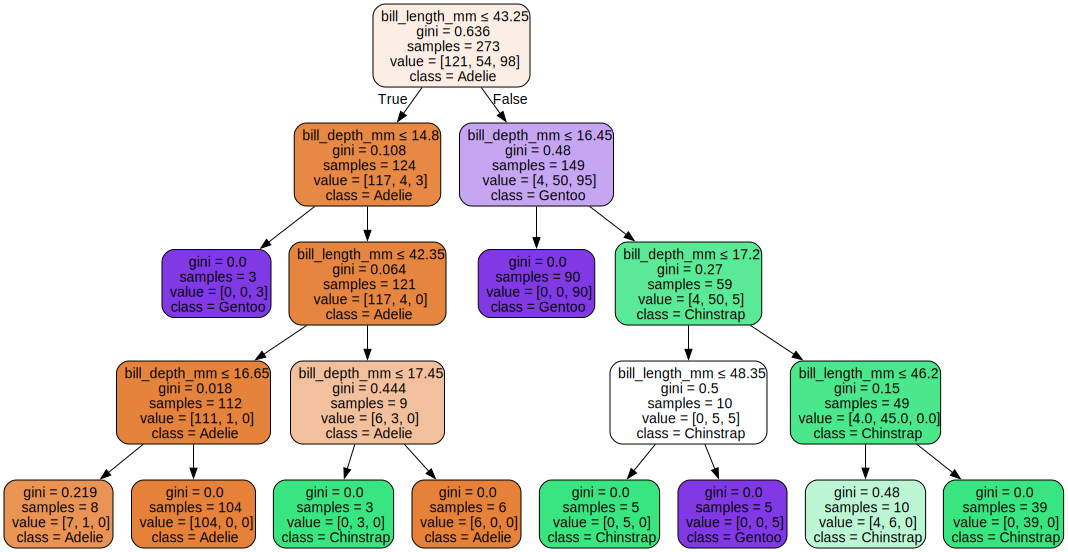

In [226]:
X, y = pipeline(df, features=['bill_length_mm', 'bill_depth_mm'])
dtc.fit(X, y)
plot_dt(dtc)

Wir sehen, dass der Baum ab der 4. Ebene im Wesentlichen versucht, nur noch einzelne Datenpunkte zu trennen.

An dieser Stelle sollten wir auf jeden Fall stoppen und anschließend überlegen, ob ein früheres Stoppen ebenfalls sinnvoll wäre und ob auf jeder Ebene tatsächlich alle Splits benötigt werden.

In [227]:
super_tree = SuperTree(dtc, X, y, dtc.feature_names_in_, dtc.classes_)
# unkommentiere die folgende Zeile, um die interaktive Baumgrafik als HTML-Datei zu speichern
# super_tree.save_html('figs/supertree.html')
super_tree.show_tree()

**Tiefe 2, Blatt 2:**  
Dieses Blatt muss nicht weiter gesplittet werden. Die Klasse ist hier eindeutig `Adelie`, und selbst bei weiteren Splits würden sich die Klassen nicht sinnvoll trennen. An dieser Stelle sollte man daher aufhören.

**Tiefe 2, Blatt 4:**  
Auch hier ist der Split nur bedingt sinnvoll, da die Klasse überwiegend `Chinstrap` ist und sich selbst mit weiteren Splits keine klare Trennung ergibt. Ob man hier stoppt oder noch weiter splittet, ist weniger eindeutig und hängt davon ab, ob die folgenden Splits tatsächlich neue Information liefern könnten.

**Tiefe 4, Blatt 7:**  
Im (Super-)Tree sehen wir, dass es für den Baum sehr schwierig ist, diese Datenpunkte weiter zu trennen. Mit diesen beiden Features scheint es daher nicht sinnvoll zu sein, weiter zu versuchen. An dieser Stelle bietet es sich an zu prüfen, ob `flipper_length_mm` helfen kann, diese Punkte besser zu unterscheiden. Abgesehen von diesen etwa zehn Punkten lassen sich die Klassen sonst sehr gut trennen, sodass dieses zusätzliche Feature hier möglicherweise einen Mehrwert liefern könnte.

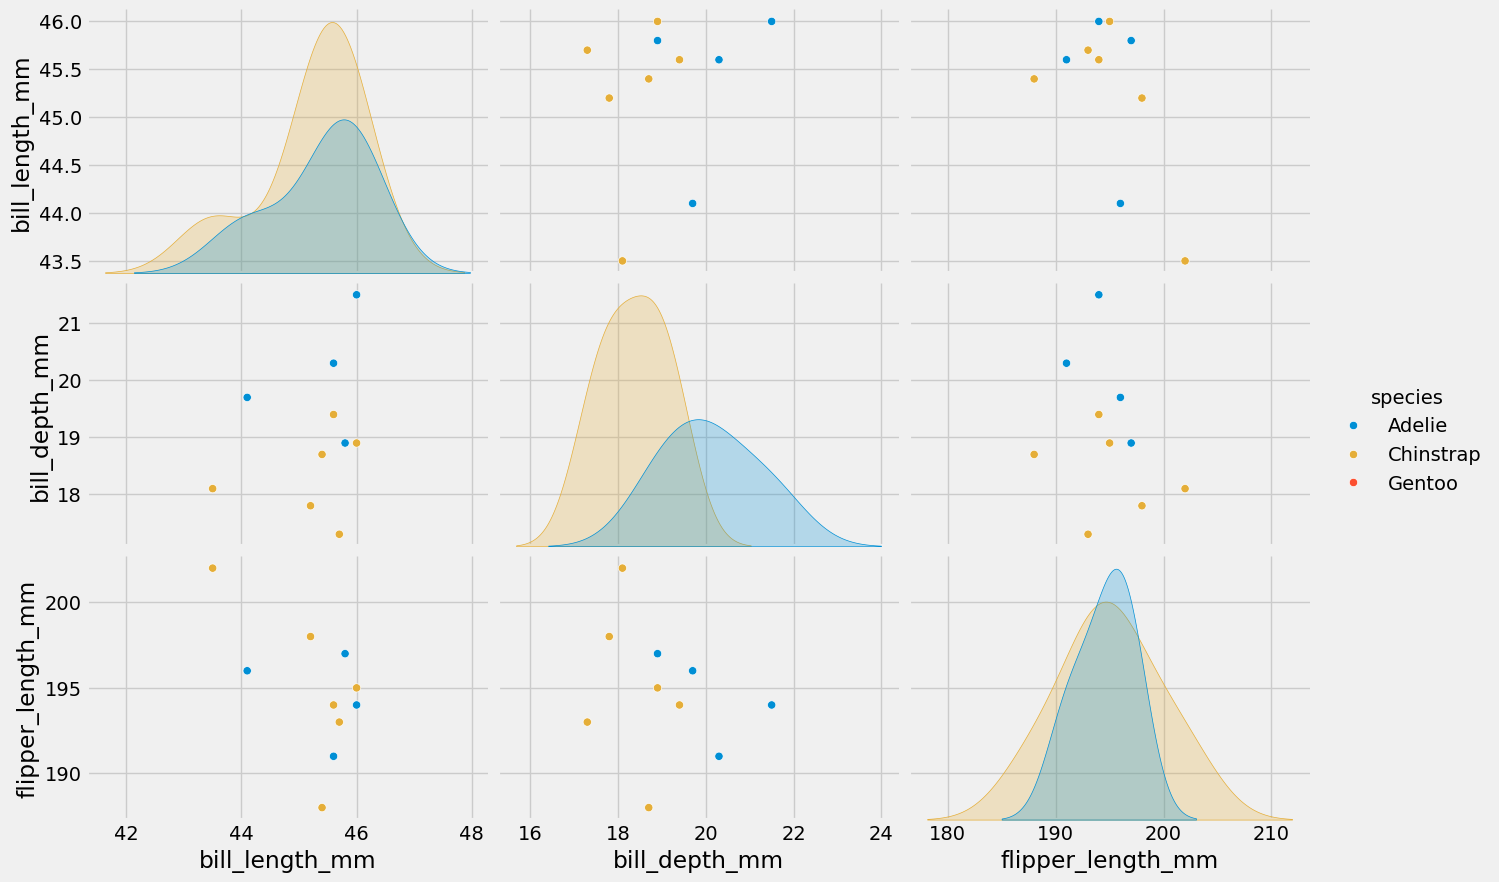

In [228]:
confusing = df.loc[(df.bill_length_mm <= 46.2) & (df.bill_depth_mm > 17.20) & (df.bill_depth_mm > 16.45) & (df.bill_length_mm > 43.25)]
sns.pairplot(confusing[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'species']], hue='species', diag_kind='kde', height=3, aspect=1.5, palette=SPECIES_PALETTE, hue_order=SPECIES_ORDER);

Hier sehen wir, dass sich diese etwa 10 Datenpunkte auch mithilfe von `flipper_length_mm` nicht sinnvoll trennen lassen. Wenn überhaupt, dann noch am ehesten über `bill_depth_mm`. Das heißt: Wenn `bill_length_mm` und `bill_depth_mm` hier bereits an ihre Grenzen stoßen, liefert `flipper_length_mm` ebenfalls keinen zusätzlichen Mehrwert.

Da der Split auf **Tiefe 2, Blatt 4** auch mit weiteren Splits (bis zu vier Ebenen tiefer) keine saubere Trennung erreicht, ist es sinnvoll, diesen Split komplett zu entfernen.

**Tiefe 1, Blatt 1:**  
Die letzte offene Entscheidung ist, ob dieser Split überhaupt benötigt wird. Er trennt lediglich drei `Gentoo` Punkte, was zunächst nach sehr wenig aussieht. Schaut man sich den SuperTree jedoch genauer an, erkennt man, dass sich diese `Gentoo` Punkte klar und mit einer großen Lücke von den anderen Klassen unterscheiden. In diesem Fall ist der Split sinnvoll und führt nicht zu Overfitting, da hier eine systematische Trennung vorliegt.

In [229]:
print(export_text(dtc, feature_names=list(X.columns)))

|--- bill_length_mm <= 43.25
|   |--- bill_depth_mm <= 14.80
|   |   |--- class: Gentoo
|   |--- bill_depth_mm >  14.80
|   |   |--- bill_length_mm <= 42.35
|   |   |   |--- bill_depth_mm <= 16.65
|   |   |   |   |--- class: Adelie
|   |   |   |--- bill_depth_mm >  16.65
|   |   |   |   |--- class: Adelie
|   |   |--- bill_length_mm >  42.35
|   |   |   |--- bill_depth_mm <= 17.45
|   |   |   |   |--- class: Chinstrap
|   |   |   |--- bill_depth_mm >  17.45
|   |   |   |   |--- class: Adelie
|--- bill_length_mm >  43.25
|   |--- bill_depth_mm <= 16.45
|   |   |--- class: Gentoo
|   |--- bill_depth_mm >  16.45
|   |   |--- bill_depth_mm <= 17.20
|   |   |   |--- bill_length_mm <= 48.35
|   |   |   |   |--- class: Chinstrap
|   |   |   |--- bill_length_mm >  48.35
|   |   |   |   |--- class: Gentoo
|   |   |--- bill_depth_mm >  17.20
|   |   |   |--- bill_length_mm <= 46.20
|   |   |   |   |--- class: Chinstrap
|   |   |   |--- bill_length_mm >  46.20
|   |   |   |   |--- class: Chinstra

Wenn wir alle zusätzlichen Blätter entfernen, erhalten wir einen sehr einfachen und gut interpretierbaren Entscheidungsbaum:

- Wenn `bill_length_mm` ≤ 43.25 **UND** `bill_depth_mm` > 14.8 → `Adelie`  
- Wenn `bill_length_mm` > 43.25 **UND** `bill_depth_mm` > 16.45 → `Chinstrap`  
- Sonst → `Gentoo`

In [230]:
X, y = pipeline(df, features=['bill_length_mm', 'bill_depth_mm'])
dtc.fit(X, y)
super_tree = SuperTree(dtc, X, y, dtc.feature_names_in_, dtc.classes_)
super_tree.save_html('figs/supertree.html')

HTML saved to figs/supertree.html


test_accuracy: 0.9603 ± 0.0466
test_f1_macro: 0.9516 ± 0.0541
test_precision_macro: 0.9623 ± 0.0437
test_recall_macro: 0.9533 ± 0.0533


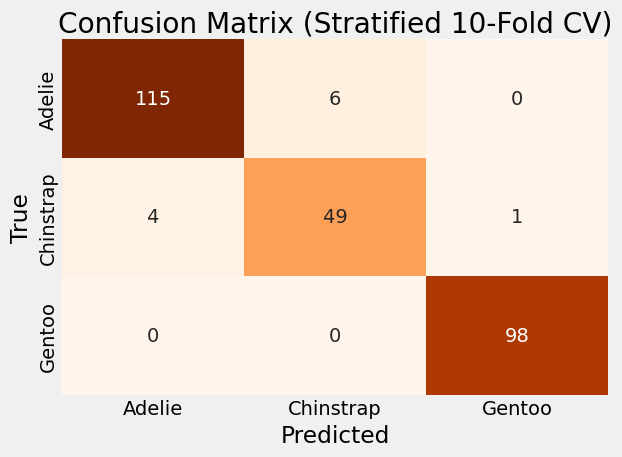

In [231]:
X, y = pipeline(df, features=['bill_length_mm', 'bill_depth_mm'])
k = 10
cv = skfcv(dtc, X, y, k=10, random_seed=RANDOM_SEED)
print_cv(cv['cv'])
plot_confusion_matrix(cv['cm'], classes=np.unique(y), title=f'Confusion Matrix (Stratified {k}-Fold CV)')

Hier schauen wir uns die Ergebnisse aus der stratifizierten Kreuzvalidierung an. Das Modell generalisiert gut und zeigt kein Precision-Recall Problem wie zuvor beim kNN.

In [232]:
def manual_rules(row):
    if row['bill_length_mm'] <= 43.25 and row['bill_depth_mm'] > 14.8:
        return 'Adelie'
    if row['bill_length_mm'] > 43.25 and row['bill_depth_mm'] > 16.45:
        return 'Chinstrap'
    return 'Gentoo'

In [233]:
# generiert von ChatGPT (Stand: 2025-12)

class ManualRuleClassifier(BaseEstimator, ClassifierMixin):

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        self.feature_names_ = X.columns.tolist()
        return self

    def predict(self, X):
        X = self._to_df(X)
        return X.apply(manual_rules, axis=1).values
    
    def _to_df(self, X):
        if isinstance(X, pd.DataFrame):
            return X
        return pd.DataFrame(X, columns=self.feature_names_)

    def predict_proba(self, X):
        X = self._to_df(X)
        preds = self.predict(X)
        class_to_idx = {c: i for i, c in enumerate(self.classes_)}
        proba = np.zeros((len(preds), len(self.classes_)))
        proba[np.arange(len(preds)), [class_to_idx[p] for p in preds]] = 1.0
        return proba

man = ManualRuleClassifier()

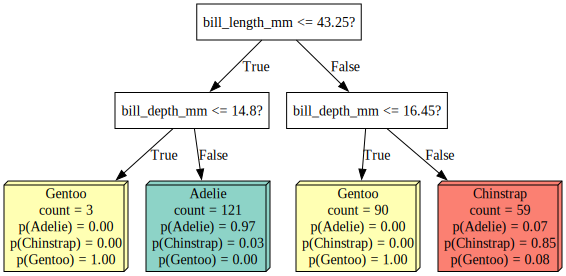

In [234]:
X, y = pipeline(df, features=['bill_length_mm', 'bill_depth_mm'])
man.fit(X, y)
plot_manual_tree(X, y)

So sieht das finale Modell aus. Es wurde bewusst sehr stark vereinfacht.

In [235]:
cv = loocv(man, X, y, metrics=['accuracy'], train_score=True)
print_cv(cv)

test_accuracy: 0.9524 ± 0.2130
train_accuracy: 0.9524 ± 0.0008


Okay, wir verlieren etwa 2% Accuracy in der LOOCV im Vergleich zum nicht vereinfachten Baum mit vier Ebenen. Das ist durchaus ein Unterschied, **aber** diese Ergebnisse beziehen sich ausschließlich auf die Trainingsdaten. Unser eigentliches Ziel sind zukünftige, bisher ungesehene Daten.

Das vereinfachte Modell ist zwar etwas weniger genau, hat aber deutlich bessere Chancen, sauber zu generalisieren. Zusätzlich liegt der Fokus dieses Projekts klar auf Interpretierbarkeit. Der vereinfachte Baum ist wesentlich leichter und direkter zu verstehen als der vorherige, komplexere Baum.

Aus diesen Gründen entscheide ich mich bewusst dafür, mit dem vereinfachten Modell weiterzuarbeiten.

test_accuracy: 0.9526 ± 0.0327
test_f1_macro: 0.9404 ± 0.0429
test_precision_macro: 0.9427 ± 0.0388
test_recall_macro: 0.9459 ± 0.0464


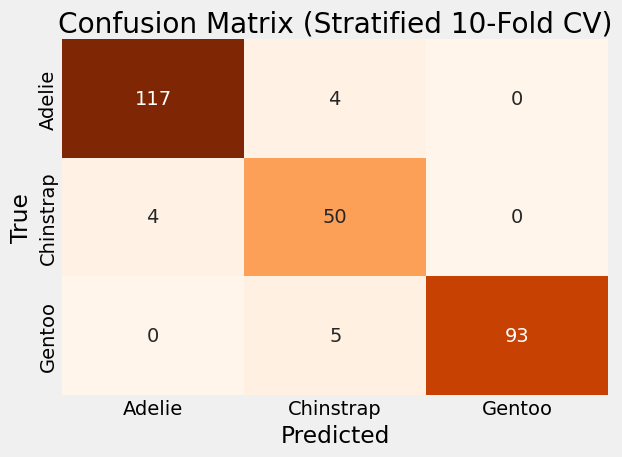

In [236]:
k = 10
cv = skfcv(man, X, y, k=k, random_seed=RANDOM_SEED)
print_cv(cv['cv'])
plot_confusion_matrix(cv['cm'], classes=np.unique(y), title=f'Confusion Matrix (Stratified {k}-Fold CV)')

Das Modell zeigt kein generelles Precision-Recall Problem. Es ist lediglich (ähnlich wie bei GNB) insgesamt schwächer in der Vorhersage der Klasse `Chinstrap`.

In [237]:
X, y = pipeline(df, features=['bill_length_mm', 'bill_depth_mm'])

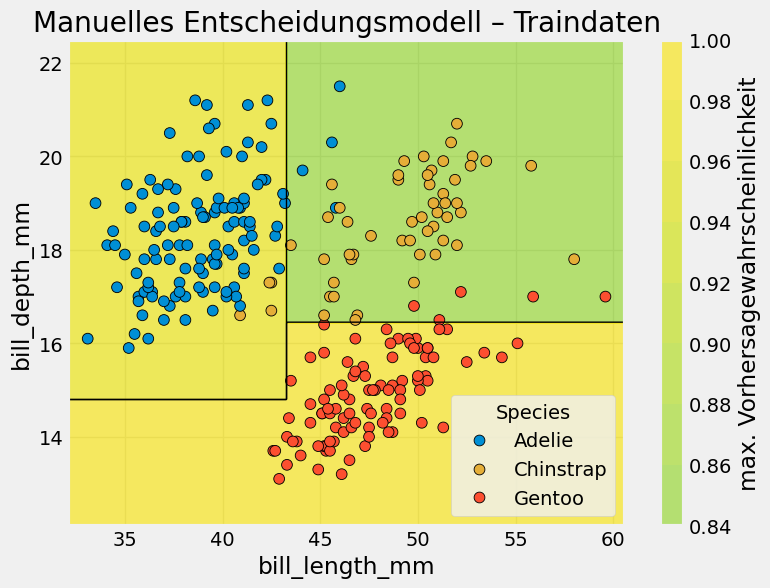

In [238]:
# generiert von ChatGPT (Stand: 2025-12)

cont, ax = plot_decision_boundary(
    X, y,
    manual=True,
    manual_rules=manual_rules,
    get_leaf_masks=get_leaf_masks,
    model_name="Manuelles Entscheidungsmodell",
    which_points="train",
    class_order=SPECIES_ORDER,
    palette=SPECIES_PALETTE
)
fig = ax.get_figure()
fig.colorbar(cont, ax=ax, label="max. Vorhersagewahrscheinlichkeit")
plt.show()

In dieser Entscheidungsgrenze sehen wir im Grunde das gleiche Problem wie bei GNB, allerdings aus einem anderen Grund. Dort lag das Problem in der Annahme einer Normalverteilung. Hier liegt es an der Annahme achsenparalleler Entscheidungsgrenzen. 

Wenn der Baum die Freiheit hätte, Entscheidungsgrenzen zu verwenden, die nicht achsenparallel sind, könnte er diese Klassen deutlich besser trennen. Da CART-Entscheidungsbäume jedoch ausschließlich achsenparallele Splits erlauben, ist diese Einschränkung hier klar sichtbar.

## Modellauswahl

In [239]:
X, y = pipeline(df, features=['bill_length_mm', 'bill_depth_mm'])

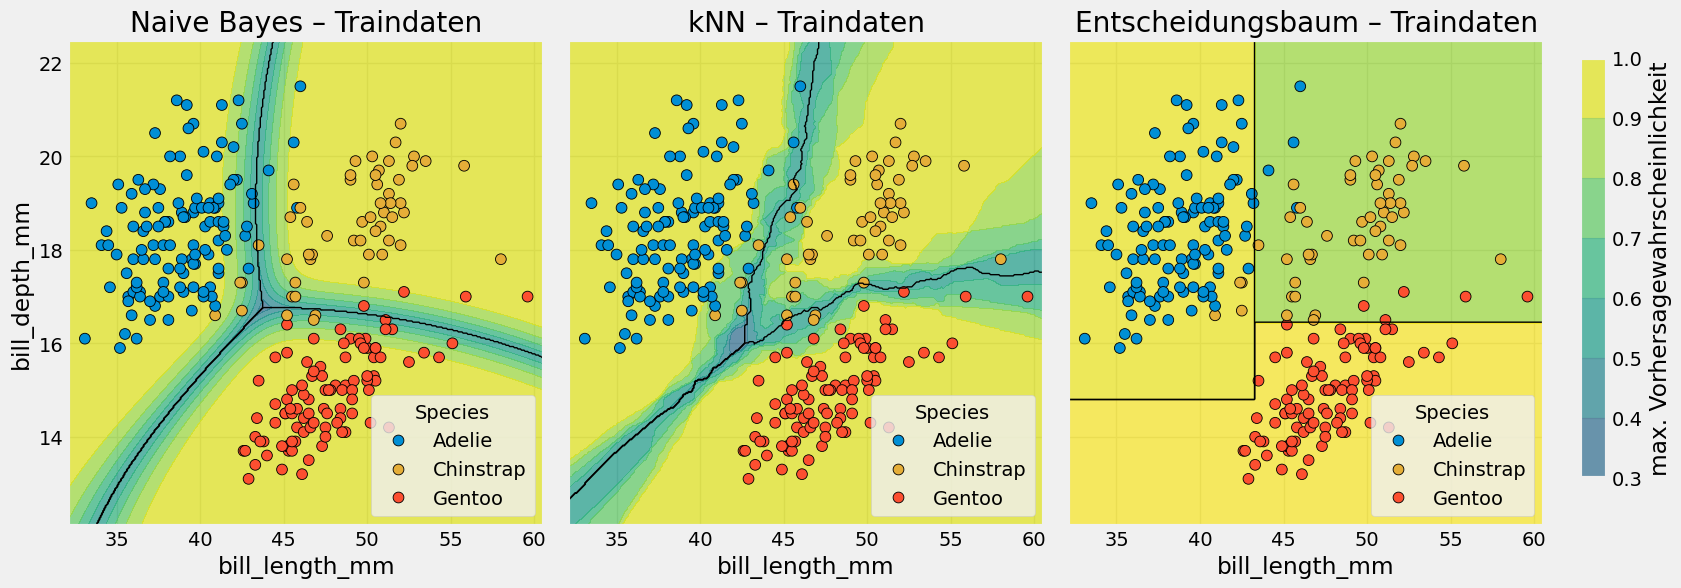

In [240]:
# generiert von ChatGPT (Stand: 2025-12)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

# 1. Naive Bayes
cont1, _ = plot_decision_boundary(
    X, y,
    model=gnb,
    model_name="Naive Bayes",
    which_points="train",
    manual=False,
    ax=axes[0],
    class_order=SPECIES_ORDER,
    palette=SPECIES_PALETTE
)

# 2. kNN
cont2, _ = plot_decision_boundary(
    X, y,
    model=knn,
    model_name="kNN",
    which_points="train",
    manual=False,
    ax=axes[1],
    class_order=SPECIES_ORDER,
    palette=SPECIES_PALETTE
)

# 3. Manuelles Modell
cont3, _ = plot_decision_boundary(
    X, y,
    manual=True,
    manual_rules=manual_rules,
    get_leaf_masks=get_leaf_masks,
    model_name="Entscheidungsbaum",
    which_points="train",
    ax=axes[2],
    class_order=SPECIES_ORDER,
    palette=SPECIES_PALETTE
)

# Gemeinsame Colorbar
fig.subplots_adjust(right=0.9, wspace=0.05)
cax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(cont1, cax=cax, label="max. Vorhersagewahrscheinlichkeit")

plt.show()

In [241]:
X, y = pipeline(df, features=['bill_length_mm', 'bill_depth_mm'])
k = 10
cv_gnb = skfcv(gnb, X, y, k=k, random_seed=RANDOM_SEED, train_score=True)
cv_knn = skfcv(knn, X, y, k=k, random_seed=RANDOM_SEED, train_score=True)
cv_man = skfcv(man, X, y, k=k, random_seed=RANDOM_SEED, train_score=True)

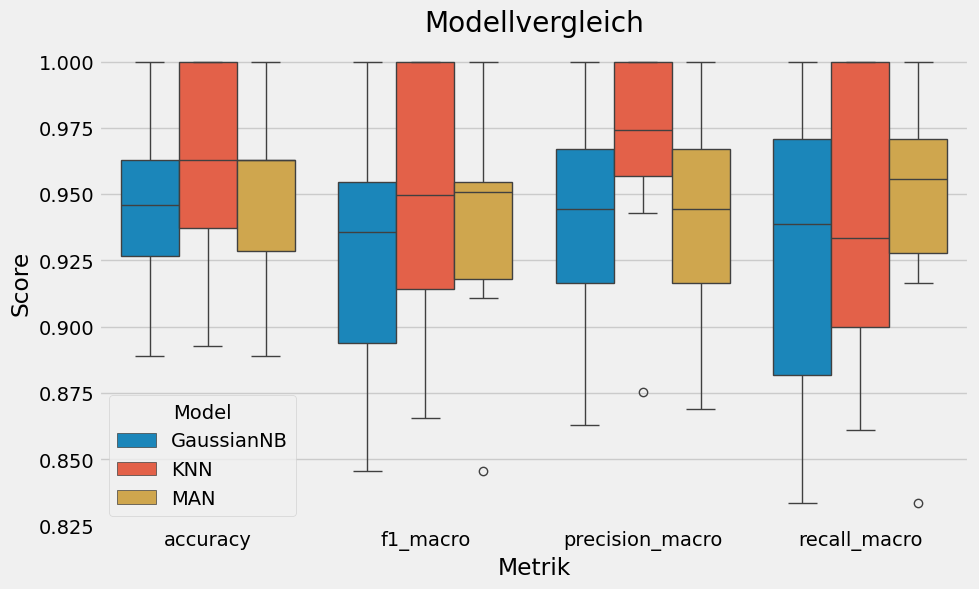

In [242]:
df_gnb = pd.DataFrame({
    "model": "GaussianNB",
    "accuracy": cv_gnb['cv']["test_accuracy"],
    "f1_macro": cv_gnb['cv']["test_f1_macro"],
    "precision_macro": cv_gnb['cv']["test_precision_macro"],
    "recall_macro": cv_gnb['cv']["test_recall_macro"]
})

df_knn = pd.DataFrame({
    "model": "KNN",
    "accuracy": cv_knn['cv']["test_accuracy"],
    "f1_macro": cv_knn['cv']["test_f1_macro"],
    "precision_macro": cv_knn['cv']["test_precision_macro"],
    "recall_macro": cv_knn['cv']["test_recall_macro"]
})

df_man = pd.DataFrame({
    "model": "MAN",
    "accuracy": cv_man['cv']["test_accuracy"],
    "f1_macro": cv_man['cv']["test_f1_macro"],
    "precision_macro": cv_man['cv']["test_precision_macro"],
    "recall_macro": cv_man['cv']["test_recall_macro"]
})

cv_df = pd.concat([df_gnb, df_knn, df_man], ignore_index=True)

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=cv_df.melt(id_vars="model", var_name="metric", value_name="score"),
    x="metric",
    y="score",
    hue="model"
)
plt.title("Modellvergleich")
plt.xlabel("Metrik")
plt.ylabel("Score")
plt.legend(title="Model")
plt.show()

kNN schneidet insgesamt am besten ab, gefolgt vom manuellen Entscheidungsbaum, während GNB die niedrigste Performance zeigt. GNB ist dabei relativ stark biased, was vor allem an der Annahme einer Normalverteilung liegt.

Der Entscheidungsbaum hat hauptsächlich einen anderen Nachteil: Innerhalb einer Region weist er allen Punkten die gleiche Wahrscheinlichkeit zu. Dadurch bekommen auch Punkte, die sehr weit von der Entscheidungsgrenze entfernt liegen und eigentlich eindeutig zu einer Klasse gehören, keine besonders hohe Wahrscheinlichkeit, wenn die gesamte Region als weniger zuverlässig eingestuft wird.

kNN hat diese beiden Nachteile nicht. Es findet eine sehr flexible Entscheidungsgrenze, ohne dabei stark zu overfitten, und ordnet jedem Punkt eine eigene Wahrscheinlichkeit zu, abhängig davon, wie nah er an der Entscheidungsgrenze liegt. Dadurch funktioniert kNN in diesem Fall sehr gut. Da wir außerdem nur mit zwei Features arbeiten, kann kNN hier sogar als eine Art Quasi White Box Modell betrachtet und relativ einfach interpretiert werden. Der eigentliche Nachteil von kNN ist die langsame Inferenz, da für jede Vorhersage alle Trainingspunkte betrachtet werden müssen. Das wird jedoch erst dann problematisch, wenn sehr viele Datenpunkte vorliegen. Unter diesen Bedingungen wäre kNN eine klare Wahl.

Man muss allerdings beachten, dass der Vergleich zwischen kNN und dem Entscheidungsbaum nicht ganz fair ist. kNN erhält hier maximale Freiheit, während der Entscheidungsbaum bewusst manuell auf maximal drei Splits beschränkt wurde. Wir haben zuvor gesehen, dass ein Entscheidungsbaum mit vier Ebenen deutlich besser abschneidet als kNN. Wenn reine Performance das wichtigste Kriterium wäre, sollte daher eher ein tieferer Entscheidungsbaum verwendet werden.

Da ich mich in diesem Projekt jedoch bewusst für Einfachheit und Interpretierbarkeit entschieden habe, ist die Performance des manuellen Entscheidungsbaums dennoch sehr solide. Aus diesem Grund entscheide ich mich, weiterhin mit dem vereinfachten Entscheidungsbaum zu arbeiten.

In [243]:
cv_df.groupby("model").agg(["mean", "std"])

accuracy            f1_macro           precision_macro            \
                mean       std      mean       std            mean       std   
model                                                                          
GaussianNB  0.945370  0.039140  0.929205  0.052576        0.937317  0.047616   
KNN         0.963624  0.037936  0.950626  0.050333        0.968891  0.038944   
MAN         0.952646  0.034503  0.940430  0.045255        0.942674  0.040874   

           recall_macro            
                   mean       std  
model                              
GaussianNB     0.930370  0.057960  
KNN            0.941667  0.056489  
MAN            0.945926  0.048869

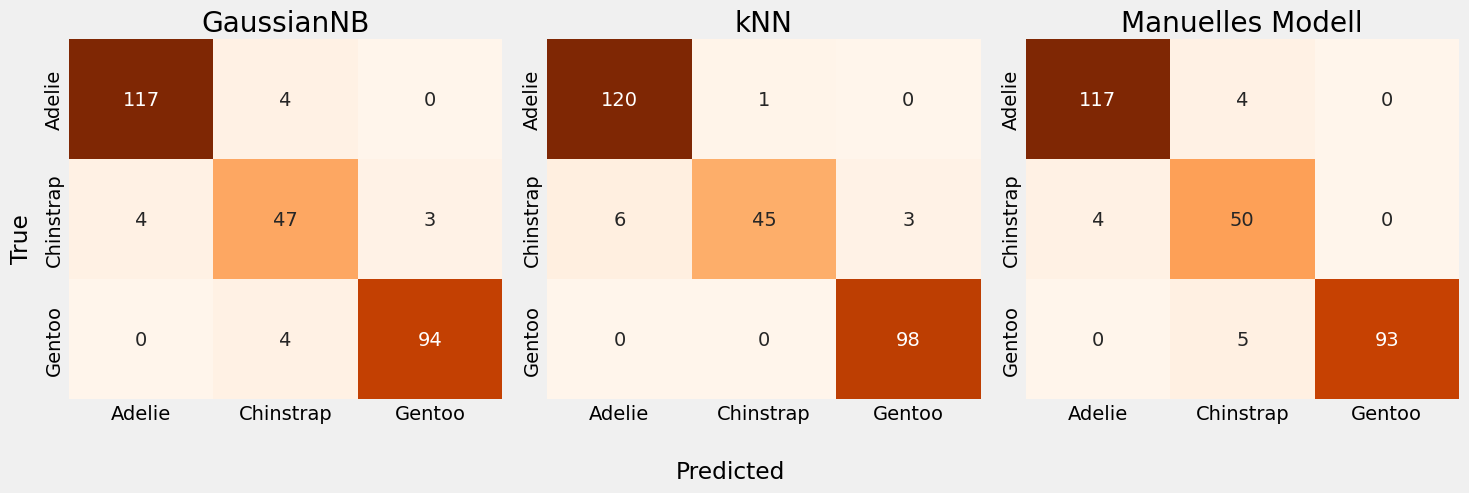

In [244]:
cm_gnb = cv_gnb['cm']
cm_knn = cv_knn['cm']
cm_man = cv_man['cm']
classes = np.unique(y)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_confusion_matrix(cm_gnb, classes, title="GaussianNB", ax=axes[0], ylabel=None, xlabel=None)
plot_confusion_matrix(cm_knn, classes, title="kNN", ax=axes[1], ylabel=None, xlabel=None)
plot_confusion_matrix(cm_man, classes, title="Manuelles Modell", ax=axes[2], ylabel=None, xlabel=None)
fig.supxlabel("Predicted")
fig.supylabel("True")
fig.tight_layout()
plt.show()

kNN zeigt für die Klasse `Chinstrap` einen vergleichsweise schlechten Recall. In diesem Punkt schneidet sogar GNB besser ab, da GNB diese Klasse seltener übersieht.

## Boostrapping

Zur zusätzlichen Einordnung der Modellperformance wurde einmalig das Bootstrap Verfahren mit 1000 Stichproben auf dem finalen Modell angewendet. Daraus ergeben sich folgende Schätzungen:

In [245]:
res = bootstrapping(man, X, y, B=1000, random_state=RANDOM_SEED, alpha=0.05)

acc = res["accuracy"]
f1  = res["f1_macro"]

print(f"Accuracy: {acc['mean']:.3f} (CI: {acc['ci'][0]:.3f}–{acc['ci'][1]:.3f}), alpha={acc['alpha']}, n={acc['n_effective']}")
print(f"Macro-F1: {f1['mean']:.3f} (CI: {f1['ci'][0]:.3f}–{f1['ci'][1]:.3f}), alpha={f1['alpha']}, n={f1['n_effective']}")

Accuracy: 0.952 (CI: 0.918–0.982), alpha=0.05, n=1000
Macro-F1: 0.941 (CI: 0.896–0.979), alpha=0.05, n=1000


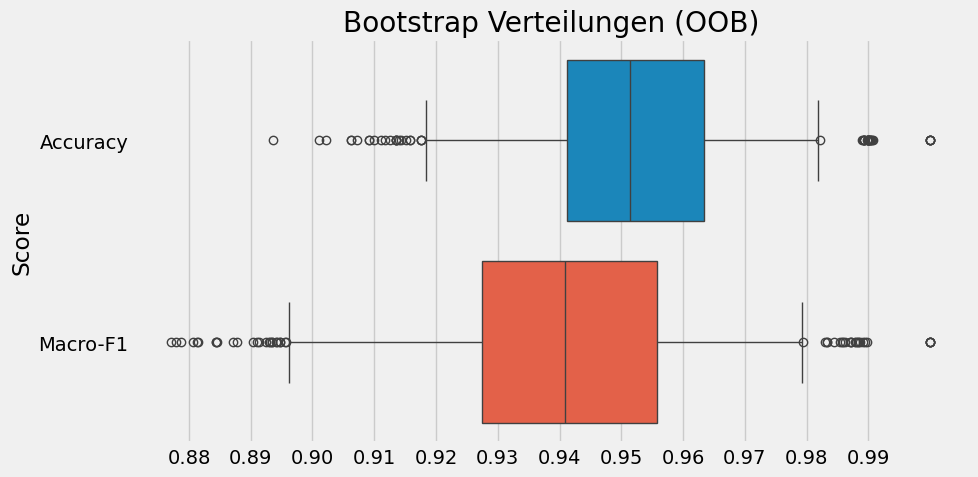

In [246]:
fig, ax = plt.subplots(figsize=(10, 5))

df_plot = pd.DataFrame({
    "score": pd.concat([
        pd.Series(acc["distribution"], name="Accuracy"),
        pd.Series(f1["distribution"],  name="Macro-F1")
    ], ignore_index=True),
    "metric": (
        ["Accuracy"] * len(acc["distribution"]) +
        ["Macro-F1"] * len(f1["distribution"])
    )
})

sns.boxplot(
    data=df_plot,
    x="score",
    y="metric",
    hue="metric",
    whis=(2.5, 97.5)
)

plt.ylabel("Score")
plt.xlabel("")
plt.title("Bootstrap Verteilungen (OOB)")
plt.xticks(np.arange(0.88, 1.00, 0.01))

plt.tight_layout()
plt.show()

Bevor wir die Testdaten betrachten, habe ich einmalig das Bootstrap Verfahren mit OOB Metriken auf dem finalen Modell angewendet, um eine realistischere Einschätzung der Performance Unsicherheit zu erhalten. Diese Analyse diente ausschließlich der Quantifizierung der Streuung und wurde nicht zur Modellselektion oder Anpassung genutzt.

# Auswertung

## Evaluation

Jetzt ist der Moment der Wahrheit. Wir testen nun das final ausgewählte Modell auf den Testdaten. Als finales Modell habe ich den manuell konstruierten Entscheidungsbaum gewählt.

**Anmerkung:** Diese Testdaten wurden bisher nicht verwendet, weder für die explorative Datenanalyse noch für die Modellierung. Aus diesem Grund sollten sie einen guten Schätzer für die Performance auf zukünftigen, bisher ungesehenen Daten liefern.

In [247]:
show_missing_values(df_test)

              precision    recall  f1-score   support

      Adelie     0.9667    0.9667    0.9667        30
   Chinstrap     0.7500    0.8571    0.8000        14
      Gentoo     0.9565    0.8800    0.9167        25

    accuracy                         0.9130        69
   macro avg     0.8911    0.9013    0.8944        69
weighted avg     0.9190    0.9130    0.9147        69



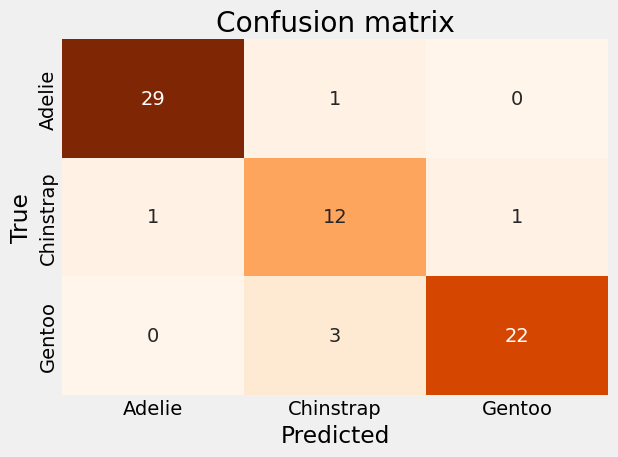

In [248]:
X, y = pipeline(df_test, features=['bill_length_mm', 'bill_depth_mm'])
y_pred = man.predict(X)
classes = np.unique(y)
print(classification_report(y, y_pred, digits=4))
cm_test = confusion_matrix(y, y_pred, labels=classes)
plot_confusion_matrix(cm_test, classes)

Dieses Ergebnis habe ich in dieser Form bereits erwartet. Mit einem voll ausgebauten Entscheidungsbaum oder mit kNN hätten sich vermutlich bessere Ergebnisse erzielen lassen. Interessant ist zudem, dass die Test Accuracy leicht unterhalb des Bootstrap Intervalls liegt, was zunächst unerwartet war. Bei der geringen Größe des Testsets ist dieses Ergebnis jedoch gut durch zufällige Schwankungen erklärbar. Dennoch bin ich mit dem gewählten Modell zufrieden, da es eine sehr schnelle und klare Interpretierbarkeit ermöglicht.

Das folgt derselben Idee wie bei klinischen Score Modellen: Die Entscheidungslogik ist vollständig transparent, lokal interpretierbar und erlaubt es, Modellvorhersagen kritisch nachzuvollziehen, anstatt sie ungeprüft zu akzeptieren. Genau aus diesem Grund sind solche Modelle in der klinischen Praxis weit verbreitet und etabliert.

In [249]:
X_train, y_train = pipeline(df, features=['bill_length_mm', 'bill_depth_mm'])
X_test, y_test = pipeline(df_test, features=['bill_length_mm', 'bill_depth_mm'])

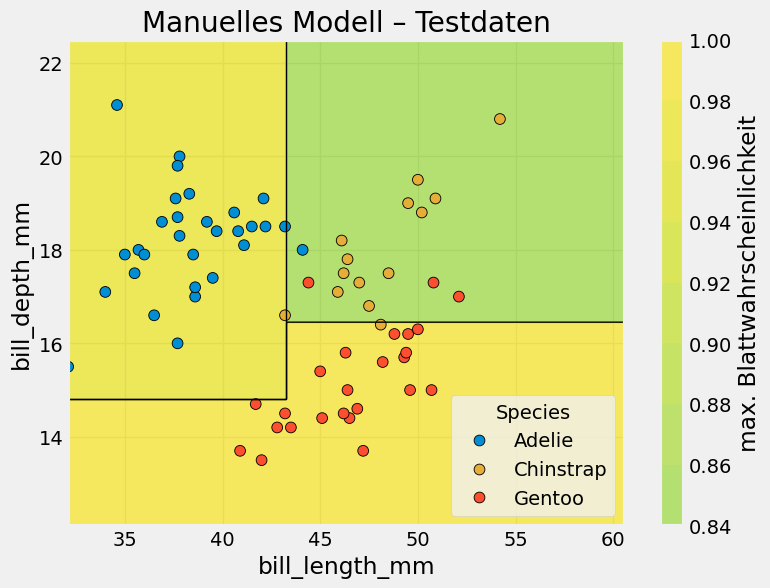

In [250]:
# generiert von ChatGPT (Stand: 2025-12)

cont, ax = plot_decision_boundary(
    X_train, y_train,
    X_test_2d=X_test,
    y_test_2d=y_test,
    which_points="test",
    manual=True,
    manual_rules=manual_rules,
    get_leaf_masks=get_leaf_masks,
    model_name="Manuelles Modell",
    class_order=SPECIES_ORDER,
    palette=SPECIES_PALETTE
)

fig = ax.get_figure()
fig.colorbar(cont, ax=ax, label="max. Blattwahrscheinlichkeit")
plt.show()

Die Testdaten zeigen genau an den gleichen Stellen Probleme, an denen wir auch bereits bei den Trainingsdaten Schwierigkeiten gesehen haben. Das ist ein klares Zeichen für Underfitting: Das Modell könnte diese Muster grundsätzlich lernen, wenn wir es weniger stark eingeschränkt hätten.

Wir haben uns jedoch bewusst für diese Einschränkung entschieden. Der Fokus liegt nicht auf maximaler Performance, sondern auf Einfachheit, Stabilität und guter Interpretierbarkeit.

## Interpretation

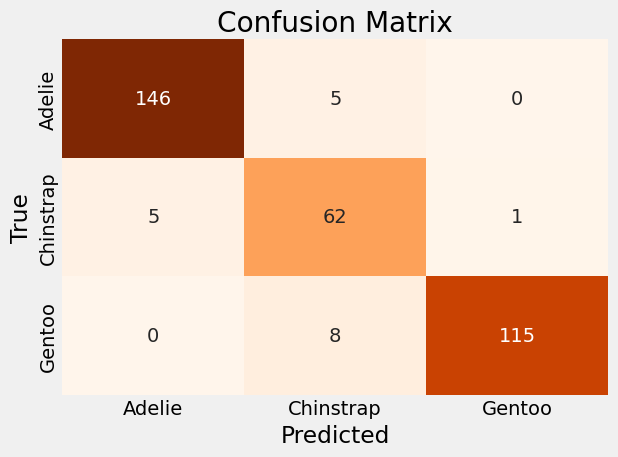

In [251]:
df_final = pd.concat([df, df_test])
X, y = pipeline(df_final, features=['bill_length_mm', 'bill_depth_mm'])
y_pred = man.predict(X)
cm = confusion_matrix(y, y_pred, labels=np.unique(y))
plot_confusion_matrix(cm, classes=np.unique(y), title='Confusion Matrix')

Wir schauen uns jetzt genauer an, warum das Modell bestimmte Fehler macht. Zum Beispiel: Warum sagt es 5 Mal `Chinstrap`, obwohl die tatsächliche Klasse `Adelie` ist?

In [252]:
df_final['species_pred'] = np.nan
df_final['species_pred'] = df_final['species_pred'].fillna('Adelie').astype(object)
df_final.loc[X.index, 'species_pred'] = y_pred
df_final.head()

island  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
98       Dream            33.1           16.1              178.0       2900.0   
114     Biscoe            39.6           20.7              191.0       3900.0   
118  Torgersen            35.7           17.0              189.0       3350.0   
303     Biscoe            50.0           15.9              224.0       5350.0   
343     Biscoe            49.9           16.1              213.0       5400.0   

        sex species species_pred  
98   Female  Adelie       Adelie  
114  Female  Adelie       Adelie  
118  Female  Adelie       Adelie  
303    Male  Gentoo       Gentoo  
343    Male  Gentoo       Gentoo

In [253]:
wrong_pred = df_final.loc[df_final.species != df_final.species_pred]
wrong_pred

island  bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g  \
19   Torgersen            46.0           21.5              194.0       4200.0   
285     Biscoe            49.8           16.8              230.0       5700.0   
319     Biscoe            51.1           16.5              225.0       5250.0   
206      Dream            42.5           17.3              187.0       3350.0   
184      Dream            42.5           16.7              187.0       3350.0   
73   Torgersen            45.8           18.9              197.0       4150.0   
182      Dream            40.9           16.6              187.0       3200.0   
43       Dream            44.1           19.7              196.0       4400.0   
321     Biscoe            55.9           17.0              228.0       5600.0   
111     Biscoe            45.6           20.3              191.0       4600.0   
339     Biscoe             NaN            NaN                NaN          NaN   
253     Biscoe            59.6           17.0              230.0       6050.0   
172      Dream            42.4           17.3              181.0       3600.0   
311     Biscoe            52.2           17.1              228.0       5400.0   
305     Biscoe            50.8           17.3              228.0       5600.0   
257     Biscoe            44.4           17.3              219.0       5250.0   
174      Dream            43.2           16.6              187.0       2900.0   
129  Torgersen            44.1           18.0              210.0       4000.0   
202      Dream            48.1           16.4              199.0       3325.0   
309     Biscoe            52.1           17.0              230.0       5550.0   

        sex    species species_pred  
19     Male     Adelie    Chinstrap  
285    Male     Gentoo    Chinstrap  
319    Male     Gentoo    Chinstrap  
206  Female  Chinstrap       Adelie  
184  Female  Chinstrap       Adelie  
73     Male     Adelie    Chinstrap  
182  Female  Chinstrap       Adelie  
43     Male     Adelie    Chinstrap  
321    Male     Gentoo    Chinstrap  
111    Male     Adelie    Chinstrap  
339     NaN     Gentoo       Adelie  
253    Male     Gentoo    Chinstrap  
172  Female  Chinstrap       Adelie  
311    Male     Gentoo    Chinstrap  
305    Male     Gentoo    Chinstrap  
257    Male     Gentoo    Chinstrap  
174  Female  Chinstrap       Adelie  
129    Male     Adelie    Chinstrap  
202  Female  Chinstrap       Gentoo  
309    Male     Gentoo    Chinstrap

In [254]:
chinstrap_not_adelie_idx = wrong_pred[(wrong_pred.species == 'Adelie') & (wrong_pred.species_pred == 'Chinstrap')].index.to_list()

In [255]:
man.fit(X, y)
explainer = shap.ExactExplainer(man.predict_proba, X)
shap_values = explainer(X)
shap_values.shape

(342, 2, 3)

i=73, pos=67, class_actual='Adelie', class_predicted='Chinstrap'


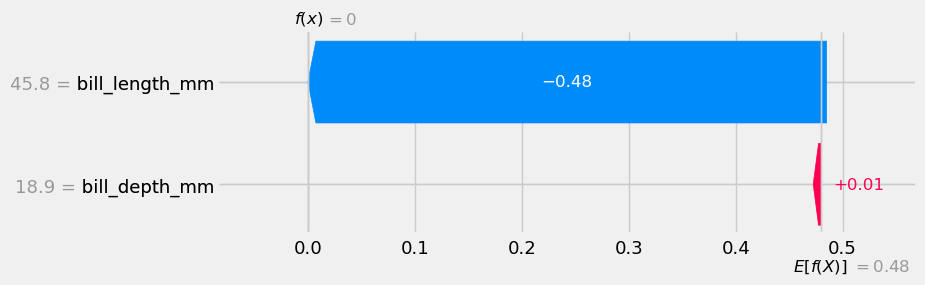

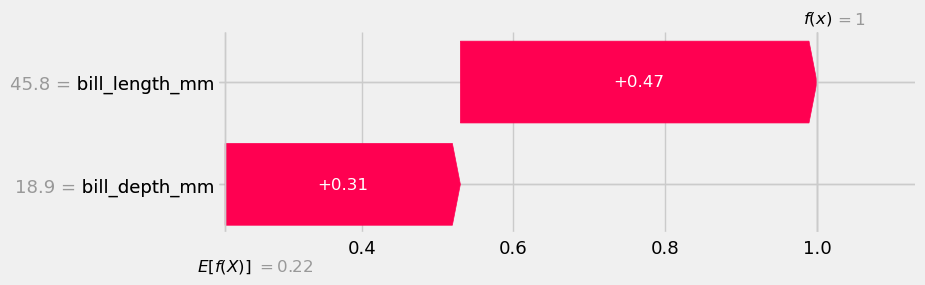

In [256]:
classes = list(np.unique(y))
i = chinstrap_not_adelie_idx[1]
class_actual = wrong_pred.loc[i, 'species']
actual_idx = classes.index(class_actual)
class_predicted = wrong_pred.loc[i, 'species_pred']
predicted_idx = classes.index(class_predicted)
pos = X.index.get_loc(i)
print(f"{i=}, {pos=}, {class_actual=}, {class_predicted=}")
shap.plots.waterfall(shap_values[pos, :, actual_idx])
shap.plots.waterfall(shap_values[pos, :, predicted_idx])

Wir sehen hier, dass `bill_length_mm` eindeutig für diese falsche Vorhersage verantwortlich ist. Konkret reduziert der Wert dieses Features im Modell die Wahrscheinlichkeit für die korrekte Klasse `Adelie` von etwa 48% auf nahezu 0%.

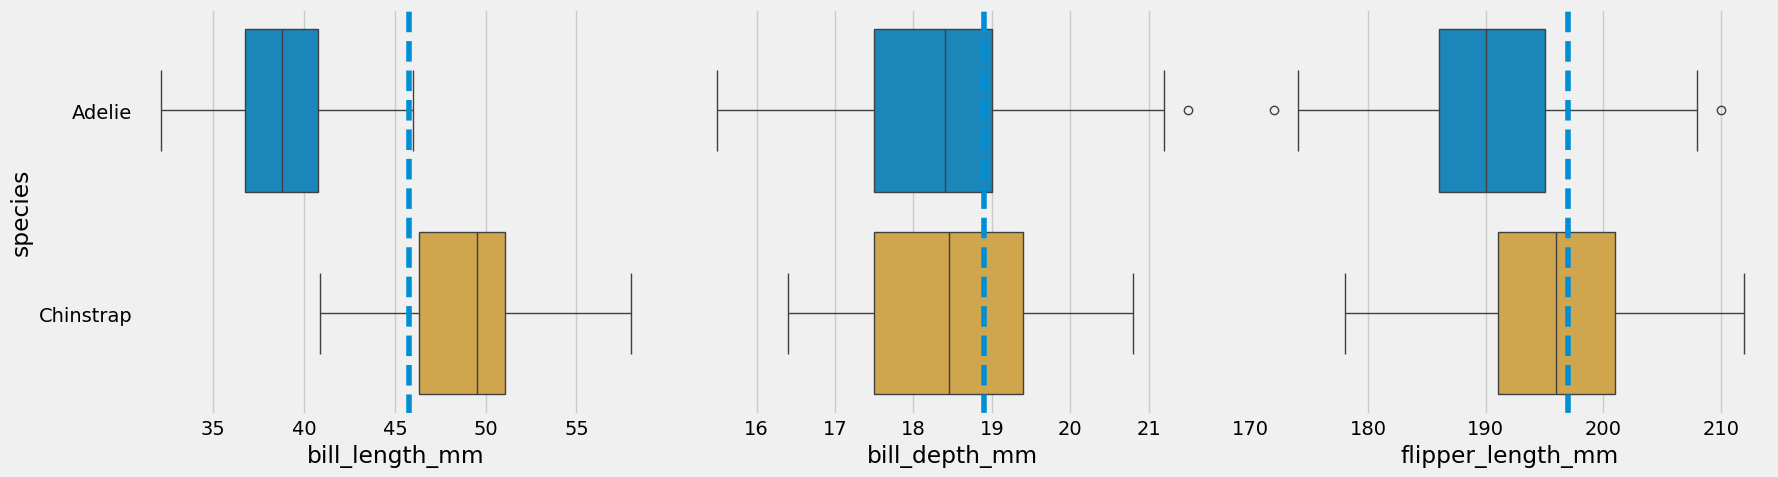

In [257]:
sub = df_final.loc[df_final.species.isin(["Adelie", "Chinstrap"])].copy()

if str(sub["species"].dtype) == "category":
    sub["species"] = sub["species"].cat.remove_unused_categories()

order = ["Adelie", "Chinstrap"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for ax, x in zip(axes, ["bill_length_mm", "bill_depth_mm", "flipper_length_mm"]):
    sns.boxplot(
        data=sub,
        x=x,
        y="species",
        order=order,
        palette={"Adelie": SPECIES_PALETTE["Adelie"], "Chinstrap": SPECIES_PALETTE["Chinstrap"]},  # Farben fix
        ax=ax,
        hue="species",
    )
    ax.axvline(df_final.loc[i, x], color=SPECIES_PALETTE['Adelie'], linestyle='--')

plt.tight_layout()
plt.show()

Hier sehen wir, dass der Wert von `bill_length_mm` deutlich näher am `Chinstrap` Cluster liegt als am `Adelie` Cluster. In diesem Fall hat das Modell also tatsächlich sinnvoll entschieden, da wir intuitiv vermutlich zur gleichen Einschätzung gekommen wären.

Man könnte überlegen, ob ein zusätzliches Feature wie `flipper_length_mm` dieses Problem lösen könnte. Im rechten Plot sehen wir jedoch, dass auch dieses Feature näher am `Chinstrap` Cluster liegt als am `Adelie` Cluster. Das könnte sogar ein Hinweis darauf sein, dass das Label dieses Datenpunkts möglicherweise falsch ist.

# Fazit

Ziel dieser Arbeit war es, ein Klassifikationsmodell für den Palmer-Penguins-Datensatz zu entwickeln, das nicht nur gute Vorhersagen liefert, sondern vor allem gut interpretierbar ist. Der Fokus lag dabei bewusst nicht auf maximaler Accuracy, sondern auf einem klar nachvollziehbaren und verständlichen Modellverhalten.

Die wenigen fehlenden Werte in relevanten Features wurden bewusst entfernt, da es sich insgesamt nur um sehr wenige Datenpunkte handelte. Für diese Entscheidung habe ich mich bewusst entschieden, da mir eine saubere Modellierung wichtiger war als für jeden einzelnen Datenpunkt eine Vorhersage zu erzwingen. Auch im Testset hätte ich fehlende Werte auf die gleiche Weise behandelt. Ausgehend von einer ausführlichen explorativen Datenanalyse habe ich anschließend verschiedene Feature-Kombinationen untersucht und drei unterschiedliche Modellfamilien miteinander verglichen, nämlich Gaussian Naive Bayes, kNN und Entscheidungsbäume. Dabei zeigte sich, dass die Merkmale `bill_length_mm` und `bill_depth_mm` den größten Beitrag zur Trennung der Klassen leisten. Weitere Features wie `flipper_length_mm`, `body_mass_g`, `sex` oder `island` lieferten entweder keine zusätzliche Information oder führten zu einer schlechteren Generalisierung.

Im Modellvergleich erzielte kNN, abgesehen von einem Entscheidungsbaum mit vier Ebenen, die beste Performance. Gleichzeitig zeigte kNN jedoch Schwächen beim Recall der Klasse `Chinstrap` und ist in der Inferenz in der Regel vergleichsweise langsam. Gaussian Naive Bayes war stark durch seine Verteilungsannahmen eingeschränkt und schnitt insbesondere bei überlappenden Klassen schlechter ab. Ein Entscheidungsbaum mit vier Ebenen funktionierte zwar am besten, wurde jedoch bewusst auf maximal drei Splits beschränkt. Dadurch entstand ein manuell vereinfachter Entscheidungsbaum, der deutlich transparenter, stabiler und einfacher zu interpretieren ist.

Das finale Modell besteht aus wenigen, klaren Entscheidungsregeln und ist damit leicht verständlich und direkt erklärbar. Die Evaluation auf dem zuvor vollständig ungenutzten Testset bestätigte die erwartete Performance und zeigte, dass die Fehlerstruktur konsistent mit den Beobachtungen aus den Trainingsdaten ist. Insgesamt erfüllt das gewählte Modell das ursprüngliche Ziel dieser Arbeit sehr gut.

# Reflexion

Rückblickend gibt es einige Strategien, die ich hätte anders oder konsequenter umsetzen können und die theoretisch zu besseren Ergebnissen geführt hätten. 
- Eine naheliegende Möglichkeit wäre gewesen, die Klassen durch ein Oversampling-Verfahren auszugleichen. Dadurch hätte man die Probleme mit der seltenen Klasse `Chinstrap` vermutlich deutlich reduzieren können, insbesondere im Hinblick auf den Recall.

- Auch der Umgang mit fehlenden Werten hätte robuster gestaltet werden können, etwa durch eine explizite Fallback-Logik oder eine getrennte Inferenz-Pipeline für unvollständige Beobachtungen.

- Ein weiterer Punkt betrifft den Umgang mit dem Feature `island`. Statt viel Zeit in die detaillierte Analyse dieses Merkmals zu investieren, hätte ich auch von Anfang an stärker von einer möglichen kontextuellen Verzerrung der Datenerhebung ausgehen und das Feature frühzeitig aus dem Modell entfernen können. Ich habe mich bewusst dagegen entschieden und `island` genauer untersucht, um die zugrunde liegenden Annahmen transparent zu machen. Am Ende zeigte sich jedoch, dass das Feature keinen ausreichenden zusätzlichen Nutzen bringt und daher ohnehin verworfen wurde.

- Auch beim manuellen Entscheidungsbaum wäre eine andere Strategie möglich gewesen. An einigen Stellen wurde sichtbar, dass bestimmte Splits lokal nicht optimal waren und dass zusätzliche Splits die Trennung einzelner Datenpunkte verbessert hätten, ohne zwangsläufig die Generalisierung stark zu verschlechtern. Mit einem weniger stark eingeschränkten Baum wären auf dem Testset vermutlich bessere Ergebnisse erzielbar gewesen.

Diese Einschränkungen habe ich jedoch bereits während der Modellierung bewusst in Kauf genommen und an den jeweiligen Stellen begründet. Ziel dieser Arbeit war es nicht, das leistungsstärkste Modell zu finden, sondern ein Modell zu entwickeln, dessen Entscheidungslogik klar, stabil und nachvollziehbar ist. Die getroffenen Entscheidungen spiegeln diesen Fokus wider, auch wenn dadurch bewusst auf einen Teil der maximal möglichen Performance verzichtet wurde.

**Hinweis:**

In dieser Arbeit wurde ChatGPT hauptsächlich zur sprachlichen Ausformulierung und zur Übersetzung von Textpassagen verwendet. Zusätzlich wurden einzelne Code-Snippets, Funktionen und Bilder mithilfe von ChatGPT generiert und an den entsprechenden Stellen explizit gekennzeichnet. Alle nicht gekennzeichneten Inhalte wurden eigenständig von mir erstellt. Für den gesamten Inhalt dieser Arbeit übernehme ich die volle Verantwortung, einschließlich der Teile, die mithilfe von ChatGPT entstanden sind.